In [37]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2
from skimage.color import rgb2gray
from skimage import io
from skimage.measure import label, regionprops
import glob
import re
from scipy.stats import ttest_ind
import seaborn as sns
from scipy import stats


class ImageAnalysis:
    
    """
    Provides methods for organizing and analyzing image data from various directory structures within a project folder.
    This class initializes by reading the project folder, creating a DataFrame that lists each directory and its path,
    and allows for further expansion to include specific image analysis metadata.

    Parameters:
    - project_folder (str): The path to the project folder containing various image data directories.

    """
    
    def __init__(self, project_folder):
        self.project_folder = project_folder
        self.directory_df = self.initialize_directory_df() 
        
    def initialize_directory_df(self):
        directories = [d for d in os.listdir(self.project_folder) if os.path.isdir(os.path.join(self.project_folder, d))]
        directory_data = [{'directory_name': d, 'directory_path': os.path.join(self.project_folder, d)} for d in directories]
        return pd.DataFrame(directory_data, columns=['directory_name', 'directory_path'])
    
    def expand_directory_df(self):
        # Add new columns with default empty lists
        self.directory_df['sensor_type'] = ''
        self.directory_df['session_id'] = ''
        self.directory_df['stimulation_ids'] = [[] for _ in range(len(self.directory_df))]
        self.directory_df['stimulation_frame_number'] = [[] for _ in range(len(self.directory_df))]

        for index, row in self.directory_df.iterrows():
            folder_name = row['directory_name']
            folder_path = row['directory_path']
            
            # Parse folder name for sensor type and session id
            parts = folder_name.split('_')
            sensor_type = 'gcamp8' if parts[0].startswith('g') else 'cablam'
            session_id = parts[0][1:] + parts[1]  # Assuming the first part is always the experiment ID

            # Update DataFrame with sensor_type and session_id
            self.directory_df.at[index, 'sensor_type'] = sensor_type
            self.directory_df.at[index, 'session_id'] = session_id

            # Check for CSV file ending in 'biolumi' or 'fluor'
            csv_filename = [f for f in os.listdir(folder_path) if (f.endswith('biolumi.csv') or f.endswith('fluor.csv'))]
            if csv_filename:
                csv_file_path = os.path.join(folder_path, csv_filename[0])
                df_csv = pd.read_csv(csv_file_path, header=None)
                stimulation_ids = df_csv.iloc[1].dropna().tolist()
                stimulation_frame_number = df_csv.iloc[0].dropna().tolist()

                # Update DataFrame with stimulation information
                self.directory_df.at[index, 'stimulation_ids'] = stimulation_ids
                self.directory_df.at[index, 'stimulation_frame_number'] = stimulation_frame_number

        return self.directory_df
        
    def max_projection_mean_values(self, tif_path):
        """
        Generates a maximum intensity projection based on the mean values of a multi-frame TIF file
        and saves it to a new subdirectory 'processed_data/processed_image_analysis_output'
        with a '_max_projection' suffix in the file name.

        Parameters:
        tif_path (str): Path to the multi-frame TIF file.

        Returns:
        str: Path to the saved maximum intensity projection image.
        """

        with Image.open(tif_path) as img:
            # Initialize a summing array with the shape of the first frame and float type for mean calculation
            sum_image = np.zeros((img.height, img.width), dtype=np.float32)

            # Sum up all frames
            for i in range(img.n_frames):
                img.seek(i)
                sum_image += np.array(img, dtype=np.float32)

            # Compute the mean image by dividing the sum by the number of frames
            mean_image = sum_image / img.n_frames
        
        # Define the new directory path
        processed_dir = os.path.join(os.path.dirname(tif_path), 'processed_data', 'processed_image_analysis_output')
        
        # Create the directory if it does not exist
        os.makedirs(processed_dir, exist_ok=True)
        
        # Create a new file path for the max projection image with the '_max_projection' suffix
        # The filename is extracted from tif_path and appended with '_max_projection.tif'
        file_name = os.path.basename(tif_path)
        max_proj_image_path = os.path.join(processed_dir, file_name.replace('.tif', '_max_projection.tif'))
       
        # Save the max projection image to the new file path
        Image.fromarray(mean_image).save(max_proj_image_path)
        
        print(f"Max projection saved: {max_proj_image_path}")
        # Return the path to the saved image
        return max_proj_image_path
    
    def analyze_all_sessions(self, function_to_apply):
        """
        Iterates over all session IDs in the directory DataFrame and applies the given function to each,
        skipping sessions that have already been processed.

        Parameters:
        function_to_apply (callable): Function to be applied to each session. It should accept a session ID.

        Returns:
        dict: A dictionary with session_ids as keys and function return values as values.
        """
        results = {}
        for session_id in self.directory_df['session_id']:
            try:
                result = function_to_apply(session_id)
                results[session_id] = result
            except Exception as e:
                print(f"An error occurred while processing session {session_id}: {e}")
        return results
    
    def analyze_session_max_projection(self, session_id):
        """
        Wrapper function to apply max_projection_mean_values to a session's TIF file,
        skipping if the max projection file already exists.

        Parameters:
        session_id (str): The session ID for which the TIF file will be processed.

        Returns:
        str: Path to the processed max projection TIFF file or a message indicating it was skipped.
        """
        tif_path = self.get_session_raw_data(session_id)
        if isinstance(tif_path, str) and tif_path.endswith('.tif'):
            # Check if max projection file already exists
            directory_path = os.path.dirname(tif_path)
            processed_dir = os.path.join(directory_path, 'processed_data', 'processed_image_analysis_output')
            max_proj_filename = os.path.basename(tif_path).replace('.tif', '_max_projection.tif')
            max_proj_path = os.path.join(processed_dir, max_proj_filename)
            
            if os.path.exists(max_proj_path):
                print(f"Max projection file already exists for session {session_id}. Skipping.")
                return max_proj_path
            else:
                print(f"Generating max projection for session {session_id}...")
                return self.max_projection_mean_values(tif_path)
        else:
            return f"No valid TIF file found for session {session_id}"
        
    def get_session_raw_data(self, session_id):
        # Check if the session_id is in the 'session_id' column of the directory_df
        if session_id in self.directory_df['session_id'].tolist():
            # Find the directory path for the given session_id
            directory_path = self.directory_df[self.directory_df['session_id'] == session_id]['directory_path'].values[0]
            
            # Search for the .tif file within that directory
            for file_name in os.listdir(directory_path):
                if file_name.endswith('.tif'):
                    return os.path.join(directory_path, file_name)

            # If no .tif file is found in the directory
            return f"No .tif file found in the directory for session {session_id}."
        else:
            # If the session_id is not present in the DataFrame
            return f"Session ID {session_id} is not present in the directory DataFrame."
         
    def add_tiff_dimensions(self):
        """
        Analyzes the dimensions of TIF files in the directory DataFrame and adds this data as new columns.
        """
        # Ensure the DataFrame has the columns for dimensions
        if 'x_dim' not in self.directory_df.columns:
            self.directory_df['x_dim'] = None
            self.directory_df['y_dim'] = None
            self.directory_df['z_dim_frames'] = None

        # Iterate over each session_id and update the dimensions
        for index, row in self.directory_df.iterrows():
            tif_path = self.get_session_raw_data(row['session_id'])
            if isinstance(tif_path, str) and tif_path.endswith('.tif'):
                try:
                    with Image.open(tif_path) as img:
                        self.directory_df.at[index, 'x_dim'] = img.width
                        self.directory_df.at[index, 'y_dim'] = img.height
                        # For z-dimension, count the frames
                        img.seek(0)  # Ensure the pointer is at the beginning
                        frames = 0
                        while True:
                            try:
                                img.seek(img.tell() + 1)
                                frames += 1
                            except EOFError:
                                break
                        self.directory_df.at[index, 'z_dim_frames'] = frames
                except Exception as e:
                    print(f"Could not process TIF dimensions for session {row['session_id']}: {e}")
                                 
    def analyze_all_calcium_signals(self):
        """
        Applies calcium signal extraction to all session_ids in the directory DataFrame,
        skipping sessions that have already been processed.
        """
        results = {}
        processed_dir = 'processed_data/processed_image_analysis_output'
        calcium_csv_suffix = '_calcium_signals.csv'

        for session_id in self.directory_df['session_id']:
            print(f"Processing session {session_id}...")

            # Get the directory path for this session
            directory_entry = self.directory_df[self.directory_df['session_id'] == session_id]
            if directory_entry.empty:
                print(f"  No directory entry found for session {session_id}. Skipping.")
                continue

            directory_path = directory_entry['directory_path'].values[0]
            
            # Check if the calcium signals CSV already exists
            csv_path = os.path.join(directory_path, processed_dir, f"{session_id}{calcium_csv_suffix}")
            
            if os.path.exists(csv_path):
                print(f"  Calcium signals file already exists for session {session_id}. Skipping extraction.")
                results[session_id] = csv_path
                continue

            # Ensure the ROI analysis has been done to get the labeled images
            roi_results = self.analyze_roi(session_id)
            
            # Check if analyze_roi returned a path to labeled images
            if isinstance(roi_results, tuple):
                # Extract calcium signals using the labeled ROI mask
                calcium_csv_path = self.extract_calcium_signals(session_id)
                results[session_id] = calcium_csv_path
                print(f"  Calcium signals extracted and saved for session {session_id} at {calcium_csv_path}")
            else:
                # If roi_results is an error message, pass it through
                results[session_id] = roi_results
                print(f"  Error in ROI analysis for session {session_id}: {roi_results}")

        print("Calcium signal extraction process completed.")
        return results 
     
    def analyze_roi(self, session_id):
        """
        Analyzes ROI of the 'labels_postexport.tif' file for a given session and saves two results:
        one with labels and another without labels.I t also saves the labeled image data as numpy array for future use.
        """
        
        #### SETP 1: DEFINE PATHS ####
        # define the paths, including the directory where processed images will be saved (processed_dir) 
        # and the name of the TIF file that contains the ROI labels (consistent_file_name)
        processed_dir = 'processed_data/processed_image_analysis_output'
        consistent_file_name = 'labels_postexport.tif'
        output_suffix_with_labels = '_roi_analysis_with_labels.png'
        output_suffix_without_labels = '_roi_analysis_without_labels.png'

        #### STEP 2: RETRIEVE SESSION DATA ####
        # Retrieve the directory path from the DataFrame
        # looks up the session's directory path from a DataFrame (directory_df) using the provided session_id. 
        # If the session ID isn't found, it returns a message indicating no directory entry was found for that session.
        
        directory_entry = self.directory_df[self.directory_df['session_id'] == session_id]
        if directory_entry.empty:
            return f"No directory entry found for session {session_id}"

        #### STEP 3: VERIFY AND LOAD THE ROI TIF FILE ####
        # constructs the full path to the labels_postexport.tif file and checks if it exists. If it does, the file is opened and loaded. 
        # If the file is in RGB format, it's converted to grayscale using rgb2gray from skimage.color. 
        # This conversion is crucial for analyzing the image as a binary mask where non-white pixels are considered ROIs.
        directory_path = directory_entry['directory_path'].values[0]
        
        # Build the path to the postexport TIFF file
        tiff_file_path = os.path.join(directory_path, processed_dir, consistent_file_name)

        # Verify that the file exists
        if not os.path.exists(tiff_file_path):
            return f"File not found for session {session_id}"
        else:
            print(f"Analyzing session {session_id}...")
        
        #### STEP 4: CREATE AND SAVE THE BINARY MASK ####
        # k: The method then converts the grayscale image to a binary mask, identifying all non-white pixels as ROIs 
        # (pixels with value less than 1 after normalization are set to 1, and others to 0). 
        # This binary mask is labeled using label from skimage.measure, assigning a unique label to each connected component (ROI).
        
        # Load the image
        mask_image = Image.open(tiff_file_path)

        # Convert RGB image to grayscale if necessary
        if mask_image.mode == 'RGB':
            # Convert to grayscale using skimage's rgb2gray
            image_array = rgb2gray(np.array(mask_image))

        # Assuming that all non-white pixels are ROIs
        binary_mask = np.where(image_array < 1, 1, 0)  # Here, 1 corresponds to white in the normalized grayscale image

        # Label the regions
        labeled_image = label(binary_mask, connectivity=1)
        num_rois = np.max(labeled_image)
        
        # Save the labeled image data as a NumPy array file for future processing
        labeled_image_path = os.path.join(directory_path, processed_dir, f"{session_id}_labeled_image.npy")
        np.save(labeled_image_path, labeled_image)
        
        
        #### STEP 5: SAVE THE UNLABELED ROI IMAGE ####
        # Save Unlabeled ROI Image: The method saves a version of the labeled image without any annotations to a specified path (output_path_without_labels). 
        # This image is saved in the processed_image_analysis_output directory with a specific suffix to indicate it's the unlabeled version.
        
        # Save the image without labels
        output_path_without_labels = os.path.join(directory_path, processed_dir, session_id + output_suffix_without_labels)
        plt.imsave(output_path_without_labels, labeled_image, cmap='nipy_spectral')

        
        #### STEP 6: ANALYZE AND SAVE LABELED ROI IMAGE ####
        # Iterates through each detected region using regionprops, extracts the centroid, 
        # and annotates the image with the region's label. 
        # This annotated image is saved separately, indicating it includes ROI labels.
        
        # Analyze regions and save properties
        regions = regionprops(labeled_image)

        # Prepare to save the ROI analysis image with labels
        output_path_with_labels = os.path.join(directory_path, processed_dir, session_id + output_suffix_with_labels)
        
        fig, ax = plt.subplots()
        ax.imshow(labeled_image, cmap='nipy_spectral')
        ax.axis('off')

        # Annotate each ROI with its corresponding label (ID)
        for region in regions:
            # Get the coordinates of the centroid of the region
            y, x = region.centroid
            # Annotate the ROI ID at the centroid position
            ax.text(x, y, str(region.label), color='white', ha='center', va='center')

        plt.savefig(output_path_with_labels)
        plt.close()

        # Return the paths of the saved figures LABELED AND UNLABELED and number of ROIs
        return (output_path_with_labels, output_path_without_labels), num_rois
    
    def analyze_all_rois(self):
        """
        Applies ROI analysis to all sessions and saves the results.
        """
        results = {}
        for session_id in self.directory_df['session_id']:
            result = self.analyze_roi(session_id)
            results[session_id] = result
        return results
    
    def process_all_sessions(self, use_corrected_data=False):
        
        """
        This assumes the analyze_all_rois method has been previously run to generate the numpy files 
        and the corresponding images with and without labels for ROI per session.
        
        Process all sessions using either corrected or uncorrected calcium signal data.

        Parameters
        ----------
        use_corrected_data : bool, optional
            Flag indicating whether to use corrected calcium signals. Defaults to False, 
            indicating uncorrected data should be used.

        Returns
        -------
        dict
            A dictionary with processed data for all sessions, keyed by session ID.
        """
        
        all_data = {}
        
        for session_id in self.directory_df['session_id'].unique():
            stim_frame_numbers, roi_data, stimulation_ids = self.create_trial_locked_calcium_signals(session_id, use_corrected_data=use_corrected_data)
            if stim_frame_numbers and roi_data and stimulation_ids:  # Ensure data was returned
                all_data[session_id] = {
                    'stim_frame_numbers': stim_frame_numbers,
                    'roi_data': roi_data,
                    'stimulation_ids': stimulation_ids
                }
        return all_data
    
    def create_trial_locked_calcium_signals(self, session_id, use_corrected_data=False):
        """
        Generate trial-locked calcium signal data for a given session ID, allowing
        the choice between corrected and uncorrected data.
        
        Parameters
        ----------
        session_id : str
            The session ID for which to generate trial-locked signals.
        use_corrected_data : bool, optional
            Whether to use corrected calcium signal data. The default is False, which uses uncorrected data.
        
        Returns
        -------
        tuple
            A tuple containing the stimulation frame numbers, ROI data, and stimulation IDs.
        """

        processed_dir = 'processed_data/processed_image_analysis_output'
        calcium_csv_suffix = '_corrected_calcium_signals.csv' if use_corrected_data else '_calcium_signals.csv'

        directory_entry = self.directory_df[self.directory_df['session_id'] == session_id]

        if directory_entry.empty:
            print(f"No directory entry found for session {session_id}")
            return None, None, None

        directory_path = directory_entry['directory_path'].values[0]
        csv_path = os.path.join(directory_path, processed_dir, f"{session_id}{calcium_csv_suffix}")

        if not os.path.exists(csv_path):
            print(f"Calcium signals file not found for session {session_id} using {'corrected' if use_corrected_data else 'uncorrected'} data")
            return None, None, None

        calcium_signals_df = pd.read_csv(csv_path)
        stim_frame_numbers = directory_entry['stimulation_frame_number'].values[0]
        stimulation_ids = directory_entry['stimulation_ids'].values[0]

        pre_stim_frames = 10 # 10 frames before stimulation
        post_stim_frames = 100 # 100 frames after stimulation

        roi_data = {roi: {} for roi in calcium_signals_df.columns if 'ROI' in roi}

        for stim_id, stim_frame in zip(stimulation_ids, stim_frame_numbers):
            start_idx = max(stim_frame - pre_stim_frames, 0) 
            end_idx = min(stim_frame + post_stim_frames, len(calcium_signals_df))

            for roi in roi_data:
                trial = calcium_signals_df.loc[start_idx:end_idx, roi]
                roi_data[roi][(stim_id, stim_frame)] = trial.to_numpy()

        return stim_frame_numbers, roi_data, stimulation_ids
    
    def extract_calcium_signals(self, session_id):
        """
        Extracts calcium signals from time-series data using the saved labeled ROI mask
        and saves the results as a CSV file in the 'processed_image_analysis_output' directory.

        Parameters:
        session_id (str): Session ID for which to perform the analysis.

        Returns:
        str: Path to the saved CSV file containing calcium signal data.
        """
        processed_dir = 'processed_data/processed_image_analysis_output'
        calcium_csv_suffix = '_calcium_signals.csv'

        # Retrieve the directory path from the DataFrame
        directory_entry = self.directory_df[self.directory_df['session_id'] == session_id]
        if directory_entry.empty:
            return f"No directory entry found for session {session_id}"

        directory_path = directory_entry['directory_path'].values[0]

        # Path to the saved labeled image numpy file
        labeled_image_path = os.path.join(directory_path, processed_dir, f"{session_id}_labeled_image.npy")

        # Verify and load the labeled image numpy file
        if not os.path.exists(labeled_image_path):
            return f"Labeled image file not found for session {session_id}"
        labeled_image = np.load(labeled_image_path)

        # Locate and load the time-series TIFF file
        tif_files = glob.glob(os.path.join(directory_path, '*.tif'))
        tif_files = [f for f in tif_files if 'postexport' not in f and 'labels' not in f]  # Ensure it's the correct TIFF
        if not tif_files:
            return f"No time-series .tif file found in the directory for session {session_id}"
        time_series_path = tif_files[0]  # Assuming there's only one relevant TIFF file
        time_series = io.imread(time_series_path)

        # Initialize an array to store calcium signal data
        num_rois = np.max(labeled_image)
        num_frames = time_series.shape[0]
        calcium_signals = np.zeros((num_rois, num_frames))

        # Extract the signal from each ROI in each frame
        for t in range(num_frames):
            frame = time_series[t]
            for roi in range(1, num_rois + 1):
                roi_mask = labeled_image == roi
                roi_data = frame[roi_mask]
                calcium_signals[roi - 1, t] = np.mean(roi_data)

        # Create and save the DataFrame with calcium signals
        calcium_df = pd.DataFrame(calcium_signals.T, columns=[f"ROI_{i}" for i in range(1, num_rois + 1)])
        calcium_df['Frame'] = np.arange(1, num_frames + 1)
        csv_path = os.path.join(directory_path, processed_dir, f"{session_id}{calcium_csv_suffix}")
        calcium_df.to_csv(csv_path, index=False)

        return csv_path   
    
    def process_all_sessions_entire_recording(self, use_corrected_data=False):
        """
        Processes all sessions and stores calcium signal dataframes in a dictionary.

        Parameters
        ----------
        use_corrected_data : bool, optional
            Whether to use corrected calcium signal data. The default is False, which uses uncorrected data.

        Returns
        -------
        dict
            A dictionary where each key is a session ID and the value is the corresponding calcium_signals dataframe.
        """
        processed_dir = 'processed_data/processed_image_analysis_output'
        calcium_csv_suffix = '_corrected_calcium_signals.csv' if use_corrected_data else '_calcium_signals.csv'
        session_data = {}

        for session_id in self.directory_df['session_id'].unique():
            directory_entry = self.directory_df[self.directory_df['session_id'] == session_id]

            if directory_entry.empty:
                print(f"No directory entry found for session {session_id}")
                continue  # Skip this session and proceed with the next

            directory_path = directory_entry['directory_path'].values[0]
            csv_path = os.path.join(directory_path, processed_dir, f"{session_id}{calcium_csv_suffix}")

            if not os.path.exists(csv_path):
                print(f"Calcium signals file not found for session {session_id} using {'corrected' if use_corrected_data else 'uncorrected'} data")
                continue  # Skip this session and proceed with the next

            calcium_signals_df = pd.read_csv(csv_path)
            # Store the dataframe in the dictionary with session_id as the key
            session_data[session_id] = calcium_signals_df

        return session_data
        
    def calculate_responsiveness(self, all_data, pre_stim_frames=10, post_stim_frames=20, alpha=0.05, return_dataframe=False):    
        """
        This function calculates and identifies responsive cells within calcium imaging data, applying statistical 
        tests to determine whether the change in signal post-stimulation is significant compared to the pre-stimulation 
        baseline. It stores detailed metrics including means, standard deviations, and p-values for each ROI across all sessions.

        Parameters:
        - all_data (dict): Nested dictionary containing the processed calcium signal data for multiple sessions, 
        structured with session IDs as top-level keys.
        - pre_stim_frames (int): The number of frames before the stimulus used to calculate the baseline signal.
        - post_stim_frames (int): The number of frames after the stimulus used for post-stimulus signal analysis.
        - alpha (float): The significance level used to determine if a response is statistically significant.
        - return_dataframe (bool): If set to True, the function also returns a pandas DataFrame containing the computed metrics.

        Returns:
        - dict: A nested dictionary containing calculated metrics for each session ID, ROI, and stimulus event. If 
        `return_dataframe` is True, it also returns a DataFrame alongside this dictionary.

        The output dictionary follows a multi-level structure:
        - Level 1 (Session Level): Keys are session IDs, and values are dictionaries containing data for each session.
        - Level 2 (ROI Level): Within each session dictionary, keys are ROIs, and values are dictionaries with metrics for each ROI.
        - Level 3 (Stimulus Event Level): For each ROI, keys are tuples of (stimulation_id, stim_frame_number), and values 
        are dictionaries containing the metrics calculated for each stimulus event.

        Metrics included for each stimulus event:
        - 'pre_stim_mean': Mean of the signal in the pre-stimulus period.
        - 'pre_stim_sd': Standard deviation of the signal in the pre-stimulus period.
        - 'post_stim_peak': Maximum signal value in the post-stimulus period (not normalized).
        - 'post_stim_sd': Standard deviation of the signal in the post-stimulus period, excluding the peak value.
        - 'p_value': P-value from the t-test comparing pre-stimulus and post-stimulus signals.
        - 'is_responsive': Boolean indicating whether the ROI is considered responsive based on the p-value being below alpha.

        
        Returns:
        dict or (dict, pd.DataFrame): A dictionary and optionally a DataFrame containing all metrics and SDs for each session ID, ROI, and stimulus.
        """
        responsiveness_data = {}
        dataframe_rows = []

        for session_id, session_data in all_data.items():
            session_responsiveness = {}
            for roi, roi_data in session_data['roi_data'].items():
                roi_responsiveness = {}
                for (stim_id, stim_frame), signal_data in roi_data.items():
                    # Validate signal_data length
                    if signal_data.size >= (pre_stim_frames + post_stim_frames + 1):
                        pre_stim_signal = signal_data[:pre_stim_frames]
                        post_stim_signal = signal_data[pre_stim_frames + 1 : pre_stim_frames + 1 + post_stim_frames]
                        
    
                        
                        # New calculation for the entire array
                        delta_f_f_full_array = (signal_data - np.mean(signal_data[:pre_stim_frames])) / np.mean(signal_data[:pre_stim_frames])
                        
                        

                        # Calculate means and SDs
                        pre_stim_mean = np.mean(pre_stim_signal)
                        pre_stim_sd = np.std(pre_stim_signal)
                        post_stim_peak = np.nanmax(post_stim_signal) if not np.isnan(np.nanmax(post_stim_signal)) else np.nan
                        post_stim_sd = np.std(post_stim_signal[1:])  # Excluding the peak (stimulation point)
                        post_stim_peak_index = np.nanargmax(post_stim_signal) if not np.isnan(post_stim_peak) else np.nan
                        
                        #calculate the median of the post_stim_signal and the median of the pre_stim_signal
                        post_stim_median = np.median(post_stim_signal)
                        pre_stim_median = np.median(pre_stim_signal)
                        
                        #calculate the mean of the post_stim_signal and the mean of the pre_stim_signal
                        post_stim_mean = np.mean(post_stim_signal)
                        
                        # calculate the delta_f/f for the post_stim_signal and the pre_stim_signal and save entire array
                        delta_f_f_post_stim = (post_stim_signal - pre_stim_mean) / pre_stim_mean
                        
                        # calculate the peak delta_f/f for the post_stim_signal and save the value 
                        peak_delta_f_f_post_stim = (post_stim_peak - pre_stim_mean) / pre_stim_mean
                
                        # Perform t-test between normalized pre-stimulus and post-stimulus signals
                        t_stat, p_value = ttest_ind(pre_stim_signal, post_stim_signal, equal_var=False)

                        # Determine responsiveness based on the p-value without explicit prior length check
                        is_responsive = p_value < alpha if not np.isnan(p_value) else False
                        
                        # Time metrics calculations with safety checks
                        half_peak_value = post_stim_peak / 2 if not np.isnan(post_stim_peak) else np.nan
                        half_rise_index = np.where(post_stim_signal >= half_peak_value)[0][0] if np.any(post_stim_signal >= half_peak_value) else np.nan
                        half_decay_index = np.where(post_stim_signal[post_stim_peak_index:] <= half_peak_value)[0][0] + post_stim_peak_index if post_stim_peak_index and np.any(post_stim_signal[post_stim_peak_index:] <= half_peak_value) else np.nan

                        # Convert indices to milliseconds
                        # Adjusted line with conditional to ensure a minimum of 100 ms:
                        time_to_peak = max(100, post_stim_peak_index * 100) if not np.isnan(post_stim_peak_index) else np.nan
                        half_rise_time = half_rise_index * 100 if not np.isnan(half_rise_index) else np.nan
                        half_decay_time = half_decay_index * 100 if not np.isnan(half_decay_index) else np.nan

                    # Save all calculated metrics
                    roi_responsiveness[(stim_id, stim_frame)] = {
                        'pre_stim_mean': pre_stim_mean,
                        'pre_stim_sd': pre_stim_sd,
                        'post_stim_peak': post_stim_peak,
                        'post_stim_sd': post_stim_sd,
                        'p_value': p_value,
                        'post_stim_mean': post_stim_mean,
                        'delta_f_f_post_stim': delta_f_f_post_stim,
                        'pre_stim_median': pre_stim_median,
                        'post_stim_median': post_stim_median,
                        'peak_delta_f_f_post_stim': peak_delta_f_f_post_stim,
                        'is_responsive': is_responsive
                
                    }

                    # Append data for DataFrame
                    dataframe_rows.append({
                        'session_id': session_id,
                        'roi': roi,
                        'stimulation_id': stim_id,
                        'stim_frame_number': stim_frame,
                        'pre_stim_mean': pre_stim_mean,
                        'pre_stim_sd': pre_stim_sd,
                        'post_stim_peak': post_stim_peak,
                        'post_stim_sd': post_stim_sd,
                        'post_stim_mean': post_stim_mean,
                        'delta_f_f_post_stim': delta_f_f_post_stim,
                        'pre_stim_median': pre_stim_median,
                        'post_stim_median': post_stim_median,
                        'peak_delta_f_f_post_stim': peak_delta_f_f_post_stim,
                        'delta_f_f_full_array': delta_f_f_full_array,
                        'raw_signal': signal_data,
                        'p_value': p_value,
                        'time_to_peak': time_to_peak,
                        'half_rise_time': half_rise_time,
                        'half_decay_time': half_decay_time,
                        'is_responsive': is_responsive
                    })

                session_responsiveness[roi] = roi_responsiveness
            responsiveness_data[session_id] = session_responsiveness

        # Create and return DataFrame if requested
        if return_dataframe:
            responsiveness_df = pd.DataFrame(dataframe_rows)
            return responsiveness_data, responsiveness_df
        else:
            return responsiveness_data
        
    def filter_responsive_rois(self, all_data, responsiveness_data):
        """
        Creates a new data structure similar to all_data but excludes the data for non-responsive ROIs 
        for specific stimulation IDs, maintaining only responsive ROI data.

        Parameters:
        all_data (dict): Original dictionary with the complete dataset.
        responsiveness_data (dict): Dictionary containing responsiveness information for each ROI.

        Returns:
        dict: A new dictionary mirroring all_data's structure but excluding data for non-responsive ROIs per stimulus.
        """
        filtered_data = {}

        for session_id, session_content in all_data.items():
            filtered_data[session_id] = {
                'stim_frame_numbers': session_content['stim_frame_numbers'],
                'roi_data': {},
                'stimulation_ids': session_content['stimulation_ids']
            }

            for roi, roi_data in session_content['roi_data'].items():
                filtered_roi_data = {}

                for stim_key, signal_data in roi_data.items():
                    # Include the data only if the ROI is responsive for this stimulus
                    if responsiveness_data[session_id][roi].get(stim_key, {}).get('is_responsive', False):
                        filtered_roi_data[stim_key] = signal_data
                
                # Update only if there's at least one responsive stim event for the ROI
                if filtered_roi_data:
                    filtered_data[session_id]['roi_data'][roi] = filtered_roi_data

        return filtered_data
    
    def filter_responsive_rois_by_stimulation(self, session_data, responsiveness_df):
        # Initialize a dictionary to hold the filtered dataframes
        filtered_data_by_session = {}
        
        # Filter for responsive ROIs with stimulation_id == 12
        responsive_df = responsiveness_df[
            (responsiveness_df['is_responsive']) & 
            (responsiveness_df['stimulation_id'] == 12)
        ]
        
        # Group by session_id to process each session separately
        grouped_responsive_df = responsive_df.groupby('session_id')
        
        for session_id, group in grouped_responsive_df:
            # Initialize a list to collect dataframes for this session
            session_frames_list = []
            
            # Get unique ROIs for this session that are responsive
            unique_rois = group['roi'].unique()
            
            # Access the session's dataframe
            session_df = session_data.get(session_id)
            if session_df is None:
                print(f"Session ID {session_id} not found in session_data.")
                continue
            
            # Filter the session dataframe for responsive ROIs
            for roi in unique_rois:
                # Extract the ROI number and construct the column name
                roi_number = re.search(r'\d+', roi)
                if not roi_number:
                    print(f"ROI format is incorrect for {roi}")
                    continue
                roi_column_name = f'ROI_{roi_number.group()}'
                
                if roi_column_name in session_df.columns:
                    # Access the entire column for the responsive ROI
                    roi_frames_df = session_df[[roi_column_name]].copy()
                    
                    # Add the ROI frames to the list for this session
                    session_frames_list.append(roi_frames_df)
                else:
                    print(f"Column {roi_column_name} not found in session dataframe for session_id {session_id}.")
            
            # Combine the frames for the session into a single dataframe
            if session_frames_list:
                combined_frames_df = pd.concat(session_frames_list, axis=1)
                # Store the filtered data in the dictionary using the session_id as the key
                filtered_data_by_session[session_id] = combined_frames_df

        return filtered_data_by_session
    
    def plot_session_time_series(self, filtered_data_by_session):
        for session_id, session_df in filtered_data_by_session.items():
            # Calculate the nanmean signal across ROIs for the session
            median_signal = session_df.median(axis=1, skipna=True)
            
            # Setup the plot
            plt.figure(figsize=(10, 6))
            plt.title(f"Session ID: {session_id} Entire Recording ")
            plt.xlabel("Time (frames)")
            plt.ylabel("Signal (a.u.)") 
            
            # Plot each ROI time series in grey
            for column in session_df.columns:
                plt.plot(session_df.index, session_df[column], color='lightgrey', alpha=0.5, lw=0.5)
            
            # Plot the nanmean signal in blue
            plt.plot(session_df.index, median_signal, color='blue', label='Median Signal')
            
            # Add legend
            plt.legend()
            
            # Show the plot
            plt.show()

    def process_biolumi_calcium_signal(self, session_id, directory_df):
        processed_dir = 'processed_data/processed_image_analysis_output'
        calcium_csv_suffix = '_calcium_signals.csv'
        directory_entry = directory_df[directory_df['session_id'] == session_id]

        # Check if the directory_entry is empty
        if directory_entry.empty:
            print(f"No directory entry found for session {session_id}. Please check the session_id.")
            return None
        
        directory_path = directory_entry['directory_path'].values[0]
        csv_path = os.path.join(directory_path, processed_dir, str(session_id) + calcium_csv_suffix)

        
        if not os.path.exists(csv_path):
            print(f"Calcium signals file not found for session {session_id}")
            return None

        calcium_signals_df = pd.read_csv(csv_path) # import the calcium signals csv file
        
        # Correct the "Dark signal" for each ROI
#        for roi in calcium_signals_df.columns:
#            if 'ROI' in roi:  # Assuming ROI columns are prefixed with 'ROI'
#                dark_signal_median = calcium_signals_df[roi][:300].median() # Calculate the median of the first 100 frames
#                calcium_signals_df[roi] = calcium_signals_df[roi] - dark_signal_median
#                calcium_signals_df.loc[calcium_signals_df[roi] < 0, roi] = np.nan
        
        # Calculate the grand mean across all ROIs for the first 300 frames
        roi_columns = [roi for roi in calcium_signals_df.columns if 'ROI' in roi]  # Filter out ROI columns
        grand_mean = calcium_signals_df[roi_columns].iloc[:300].mean().mean()  # Calculate the grand mean of the first 300 frames

        # Subtract the grand mean from each ROI's calcium signal
        for roi in roi_columns:
            calcium_signals_df[roi] = calcium_signals_df[roi] - grand_mean
            calcium_signals_df.loc[calcium_signals_df[roi] < 0, roi] = np.nan  # Set negative values to NaN
       
        
        #save the corrected calcium signals to a new csv file in the same directory
        corrected_csv_path = os.path.join(directory_path, processed_dir, str(session_id) + '_corrected' + calcium_csv_suffix)
        calcium_signals_df.to_csv(corrected_csv_path, index=False)
        
        return calcium_signals_df

    def process_all_sessions_biolumi(self):
        unique_sessions = self.directory_df['session_id'].unique()
        for session_id in unique_sessions:
            print(f"Processing session ID: {session_id}")
            self.process_biolumi_calcium_signal(session_id, self.directory_df)
            print(f"Completed processing for session ID: {session_id}")
            
    def plot_stim_responsiveness(self, df, stim_ids=None, include='both', y_lim=None, x_lim=None, mean_color='black', figsize=(15, 5)):
        """
        Plots the delta F/F response for given stimulation IDs, filtering based on responsiveness if specified.
        Individual replicates are plotted in light grey, while the mean response is plotted in a user-defined color.
        Adds a red dotted line at the stimulation onset, considering the user-defined x-axis limits.
        Prints the number of responsive and unresponsive units for each stimulus ID on the plot.
        User can define the y-axis limits, x-axis limits, and the figure size.

        Parameters:
        - df (pd.DataFrame): DataFrame containing the responsiveness data.
        - stim_ids (list): List of stimulation IDs to plot. If None, all unique IDs in the DataFrame will be used.
        - include (str): Can be 'responsive', 'non-responsive', or 'both' to filter units based on responsiveness.
        - y_lim (tuple): A tuple of (min, max) for y-axis limits. If None, limits are automatically determined.
        - x_lim (tuple): A tuple of (min, max) for x-axis limits. If None, defaults to the entire range of the data.
        - mean_color (str): Color for the mean response line.
        - figsize (tuple): Figure dimension as (width, height).

        Returns:
        - fig (plt.Figure): The created figure.
        """

        # If stim_ids is not provided, get the unique IDs from the DataFrame and sort them
        if stim_ids is None:
            stim_ids = sorted(df['stimulation_id'].unique())
        else:
            stim_ids = sorted(stim_ids)
        
        # Adjust the x-axis to align with the pre-stimulus, stimulus onset, and post-stimulus periods
        stim_index = 9  # Index at which stimulation occurs
        total_frames = 111  # Total number of frames, including pre-stim, stim, and post-stim
        sampling_interval = 100  # Time per index in ms at 10Hz sampling rate

        # Create a figure and axes with subplots
        n_stims = len(stim_ids)
        fig, axes = plt.subplots(1, n_stims, figsize=figsize, sharey=True)

        # Adjust if we only have one subplot to make sure 'axes' is iterable
        if n_stims == 1:
            axes = [axes]

        # Set the y-axis limit if specified
        if y_lim:
            plt.setp(axes, ylim=y_lim)

        # Set the x-axis limit if specified
        if x_lim is not None:
            new_x_lim = (x_lim[0] * sampling_interval, x_lim[1] * sampling_interval)
            plt.setp(axes, xlim=new_x_lim)



        for ax, stim_id in zip(axes, stim_ids):
            # Filter the DataFrame based on the current stim_id
            stim_df = df[df['stimulation_id'] == stim_id]
            if include != 'both':
                stim_df = stim_df[stim_df['is_responsive'] == (include == 'responsive')]

            # Get the delta_f_f_full_array values for plotting
            delta_f_f_values = np.vstack(stim_df['delta_f_f_full_array'].values)

            # Calculate the time vector considering the stimulation index
            time_vector = np.arange(-stim_index, total_frames - stim_index) * sampling_interval

            # Plot individual replicates in light grey
            for trace in delta_f_f_values:
                ax.plot(time_vector, trace, color='lightgrey', linewidth=0.5)

            # Calculate mean response and plot in the specified mean_color
            mean_response = np.nanmedian(delta_f_f_values, axis=0)
            ax.plot(time_vector, mean_response, color=mean_color, label=f'Stim ID {stim_id}')

            # Add vertical line at stimulation onset if it's within the x-axis limits
            if x_lim is None or (0 >= x_lim[0] and 0 <= x_lim[1]):
                ax.axvline(x=0, color='red', linestyle='--', label='Stimulation Onset')

            # Count and display the number of responsive and unresponsive units for this stim_id
            num_responsive = len(stim_df[stim_df['is_responsive'] == True])
            num_unresponsive = len(stim_df[stim_df['is_responsive'] == False])
            info_text = f'Responsive: {num_responsive}'
            ax.text(0.95, 0.95, info_text, transform=ax.transAxes, fontsize=9,
                    verticalalignment='top', horizontalalignment='right',
                    bbox=dict(facecolor='white', alpha=0.5, edgecolor='black', boxstyle='round'))

            # Set titles and labels
            ax.set_title(f'Stim ID {stim_id}')
            ax.set_xlabel('ms', fontsize=24)
            ax.set_ylabel('ΔF/F$_o$', fontsize=24)
            #make y-axis labels larger
            ax.tick_params(axis='y', labelsize=18)
            ax.tick_params(axis='x', labelsize=18)
            ax.legend().remove()

        # To prevent x-axis labels from overlapping
        plt.tight_layout()
        
    def process_all_sessions_entire_recording_gcampbackgroundcorrected(self, sessions, rois_list, use_corrected_data=False):
        """
        Processes specified sessions, performs background correction using specified ROIs, and overwrites the original CSV file
        with the corrected data.

        Parameters
        ----------
        sessions : list
            A list of session IDs, e.g., ['2112232023'].
        rois_list : list of lists
            A list where each element is a list of ROIs to average and subtract for the corresponding session,
            e.g., [['ROI_11', 'ROI_12', 'ROI_13']].
        use_corrected_data : bool, optional
            Whether to use corrected calcium signal data. The default is False, which uses uncorrected data.

        Returns
        -------
        dict
            A dictionary where each key is a session ID and the value is the corresponding corrected calcium_signals dataframe.

        Notes
        -----
        After performing the background correction, this method will overwrite the original CSV file with the corrected data
        using the same file name and path. It replaces the file that was originally accessed.
        """
        processed_dir = 'processed_data/processed_image_analysis_output'
        calcium_csv_suffix = '_corrected_calcium_signals.csv' if use_corrected_data else '_calcium_signals.csv'
        session_data = {}

        for session_id, rois_to_average in zip(sessions, rois_list):
            # Ensure the session ID exists in directory_df
            if session_id not in self.directory_df['session_id'].unique():
                print(f"No directory entry found for session {session_id}")
                continue  # Skip this session and proceed with the next

            # Find the corresponding directory path for the session
            directory_entry = self.directory_df[self.directory_df['session_id'] == session_id]
            directory_path = directory_entry['directory_path'].values[0]
            csv_path = os.path.join(directory_path, processed_dir, f"{session_id}{calcium_csv_suffix}")

            if not os.path.exists(csv_path):
                print(f"Calcium signals file not found for session {session_id} using {'corrected' if use_corrected_data else 'uncorrected'} data")
                continue  # Skip this session and proceed with the next

            # Load the calcium signals data
            calcium_signals_df = pd.read_csv(csv_path)

            # Print the number of columns before the operation
            print(f"Session {session_id}: Number of columns before operation: {calcium_signals_df.shape[1]}")

            # Check if the ROIs to average are present in the dataframe
            if not all(roi in calcium_signals_df.columns for roi in rois_to_average):
                print(f"Some ROIs not found in session {session_id}: {rois_to_average}")
                continue  # Skip this session if any ROI is missing

            # Calculate the mean of the specified ROIs (excluding the 'Frame' column)
            rois_to_average_no_frame = [roi for roi in rois_to_average if roi != 'Frame']
            roi_mean = calcium_signals_df[rois_to_average_no_frame].mean(axis=1)

            # Subtract the mean from all columns except 'Frame'
            columns_to_subtract = calcium_signals_df.columns.difference(['Frame'])
            calcium_signals_corrected = calcium_signals_df.copy()
            calcium_signals_corrected[columns_to_subtract] = calcium_signals_corrected[columns_to_subtract].subtract(roi_mean, axis=0)

            # Drop the specified ROIs
            calcium_signals_corrected = calcium_signals_corrected.drop(columns=rois_to_average_no_frame)

            # Print the number of columns after the operation
            print(f"Session {session_id}: Number of columns after operation: {calcium_signals_corrected.shape[1]}")

            # Store the corrected dataframe in the session_data dictionary
            session_data[session_id] = calcium_signals_corrected

            # Overwrite the original CSV with the corrected data
            calcium_signals_corrected.to_csv(csv_path, index=False)
            print(f"Session {session_id}: Corrected data saved and overwrote {csv_path}")

        return session_data
    
    def plot_session_time_series_for_specific_rois(self, filtered_data_by_session, rois_to_include, frame_range=None):
        """
        Plots the time series for selected ROIs in each session with distinct colors for each ROI, 
        and converts frame numbers into time (seconds) on the x-axis based on 10Hz recording frequency.
        :param filtered_data_by_session: A dictionary where keys are session IDs and values are DataFrames containing ROI time series data.
        :param rois_to_include: A list of ROI names that should be included in the plot.
        :param frame_range: A tuple (start_frame, end_frame) specifying the range of frames to plot. If None, plot all frames.
        """
        # Define a color map to assign different colors for different ROIs
        colors = plt.cm.get_cmap('tab10', len(rois_to_include))  # 'tab10' colormap for up to 10 distinct colors
        
        for session_id, session_df in filtered_data_by_session.items():
            # Filter the DataFrame for the specified ROIs
            session_df_filtered = session_df[session_df.columns.intersection(rois_to_include)]

            if session_df_filtered.empty:
                print(f"No matching ROIs found in session {session_id} for the provided list of ROIs.")
                continue

            # If a frame range is provided, slice the DataFrame to include only those frames
            if frame_range is not None:
                start_frame, end_frame = frame_range
                session_df_filtered = session_df_filtered.iloc[start_frame:end_frame]
            else:
                start_frame, end_frame = 0, len(session_df_filtered)  # If no range is provided, use the full range

            # Convert frame indices to time (seconds) using 10Hz frequency
            time_vector = session_df_filtered.index / 10.0  # Convert frames to seconds (1 second = 10 frames)

            # Setup the plot
            plt.figure(figsize=(10, 6))
            plt.title(f"Session ID: {session_id} - Selected ROIs")
            plt.xlabel(f"Time (seconds)")  # X-axis now shows time in seconds
            plt.ylabel("Signal (a.u.)")
            
            # Plot each selected ROI time series with its own color
            for idx, column in enumerate(session_df_filtered.columns):
                plt.plot(time_vector, session_df_filtered[column], 
                         color=colors(idx), label=f'{column}', lw=1.5)
            
            # Add legend to identify each ROI by its trace color
            plt.legend(loc='best')
            
            # Show the plot
            plt.show()
            
    def compare_sessions_time_series(self, session_data_list, roi_lists, frame_ranges=None, session_labels=None, fig_size=(12, 6), dpi=300, save_dir=None, save_dpi=300):
        """
        Plots time series for selected ROIs from multiple sessions in a vertical arrangement of subplots,
        with independent x-axes for each subplot.
        
        :param session_data_list: List of dictionaries, each containing session data (output from filter_responsive_rois_by_stimulation)
        :param roi_lists: List of lists, each containing ROI names to plot for the corresponding session
        :param frame_ranges: List of tuples, each specifying (start_frame, end_frame) for the corresponding session. 
                            If None, all frames will be plotted for each session.
        :param session_labels: List of labels for each session. If None, default labels will be used.
        :param fig_size: Tuple representing the figure size (width, height) in inches.
        :param dpi: The resolution in dots per inch for display.
        :param save_dir: Directory to save the plot. If None, the plot is not saved.
        :param save_dpi: The resolution in dots per inch for saving the figure.
        """
        num_sessions = len(session_data_list)
        
        if frame_ranges is None:
            frame_ranges = [None] * num_sessions
        if session_labels is None:
            session_labels = [f'Session {i+1}' for i in range(num_sessions)]
        
        fig, axes = plt.subplots(num_sessions, 1, figsize=(fig_size[0], fig_size[1]*num_sessions), sharex=False, dpi=dpi)
        if num_sessions == 1:
            axes = [axes]
        
        for idx, (session_data, rois_to_include, frame_range, session_label) in enumerate(zip(session_data_list, roi_lists, frame_ranges, session_labels)):
            ax = axes[idx]
            
            if session_label not in session_data:
                print(f"Session {session_label} not found in the provided data.")
                continue
            
            session_df = session_data[session_label]
            session_df_filtered = session_df[session_df.columns.intersection(rois_to_include)]
            
            if session_df_filtered.empty:
                print(f"No matching ROIs found in {session_label} for the provided list of ROIs.")
                continue
            
            if frame_range is not None:
                start_frame, end_frame = frame_range
                session_df_filtered = session_df_filtered.iloc[start_frame:end_frame]
            else:
                start_frame, end_frame = 0, len(session_df_filtered)
            
            time_vector = session_df_filtered.index / 10.0  # Convert frames to seconds (1 second = 10 frames)
            
            colors = plt.cm.get_cmap('tab10', len(session_df_filtered.columns))
            for roi_idx, column in enumerate(session_df_filtered.columns):
                ax.plot(time_vector, session_df_filtered[column], 
                        color=colors(roi_idx), label=f'{column}', lw=1.5)
            
            ax.set_ylabel("Signal (a.u.)")
            ax.set_title(f"Session {session_label}")
            ax.legend(loc='upper right')
            ax.set_xlabel("Time (seconds)")  # Add x-label to each subplot
        
        plt.tight_layout()
        
        # Save the plot if a directory is specified
        if save_dir is not None:
            # Ensure the save directory exists
            os.makedirs(save_dir, exist_ok=True)
            
            # Ensure that text is saved as text in the SVG
            plt.rcParams['svg.fonttype'] = 'none'
            
            # Generate a filename that reflects the inputs
            session_names = '_'.join(session_labels)
            filename = f'{save_dir}/compare_sessions_{session_names}.svg'
            
            # Save the figure
            plt.savefig(filename, format='svg', dpi=save_dpi, transparent=True, bbox_inches='tight')
            print(f"Figure saved as {filename}")
        
        plt.show()

    def compare_sessions_time_series(self, session_data_list, roi_lists, frame_ranges=None, session_labels=None, 
                                    fig_size=(12, 6), dpi=300, save_dir=None, save_dpi=300, 
                                    responsiveness_dfs=None):
        """
        Plots time series for selected ROIs from multiple sessions in a vertical arrangement of subplots,
        with independent x-axes for each subplot and indicators for stimulation times.
        
        :param session_data_list: List of dictionaries, each containing session data (output from filter_responsive_rois_by_stimulation)
        :param roi_lists: List of lists, each containing ROI names to plot for the corresponding session
        :param frame_ranges: List of tuples, each specifying (start_frame, end_frame) for the corresponding session. 
                            If None, all frames will be plotted for each session.
        :param session_labels: List of labels for each session. If None, default labels will be used.
        :param fig_size: Tuple representing the figure size (width, height) in inches.
        :param dpi: The resolution in dots per inch for display.
        :param save_dir: Directory to save the plot. If None, the plot is not saved.
        :param save_dpi: The resolution in dots per inch for saving the figure.
        :param responsiveness_dfs: List of DataFrames containing responsiveness data for each session.
        """
        num_sessions = len(session_data_list)
        
        if frame_ranges is None:
            frame_ranges = [None] * num_sessions
        if session_labels is None:
            session_labels = [f'Session {i+1}' for i in range(num_sessions)]
        if responsiveness_dfs is None:
            responsiveness_dfs = [None] * num_sessions
        
        fig, axes = plt.subplots(num_sessions, 1, figsize=(fig_size[0], fig_size[1]*num_sessions), sharex=False, dpi=dpi)
        if num_sessions == 1:
            axes = [axes]
        
        for idx, (session_data, rois_to_include, frame_range, session_label, responsiveness_df) in enumerate(
                zip(session_data_list, roi_lists, frame_ranges, session_labels, responsiveness_dfs)):
            ax = axes[idx]
            
            if session_label not in session_data:
                print(f"Session {session_label} not found in the provided data.")
                continue
            
            session_df = session_data[session_label]
            session_df_filtered = session_df[session_df.columns.intersection(rois_to_include)]
            
            if session_df_filtered.empty:
                print(f"No matching ROIs found in {session_label} for the provided list of ROIs.")
                continue
            
            if frame_range is not None:
                start_frame, end_frame = frame_range
                session_df_filtered = session_df_filtered.iloc[start_frame:end_frame]
            else:
                start_frame, end_frame = 0, len(session_df_filtered)
            
            # Convert frame range to seconds
            start_time = start_frame / 10.0
            end_time = end_frame / 10.0
            time_vector = np.arange(len(session_df_filtered)) / 10.0  # Convert frames to seconds
            
            colors = plt.cm.get_cmap('tab10', len(session_df_filtered.columns))
            for roi_idx, column in enumerate(session_df_filtered.columns):
                ax.plot(time_vector, session_df_filtered[column], 
                        color=colors(roi_idx), label=f'{column}', lw=1.5)
            
            # Plot stimulation times if responsiveness_df is provided
            if responsiveness_df is not None:
                stim_data = responsiveness_df[
                    (responsiveness_df['session_id'] == session_label) & 
                    (responsiveness_df['roi'].isin(rois_to_include)) &
                    (responsiveness_df['stim_frame_number'].between(start_frame, end_frame))
                ][['stim_frame_number', 'stimulation_id']].drop_duplicates()
                
                for _, stim_row in stim_data.iterrows():
                    stim_frame = stim_row['stim_frame_number']
                    stim_id = stim_row['stimulation_id']
                    stim_time = (stim_frame - start_frame) / 10.0  # Convert to seconds relative to start_time
                    ax.axvline(x=stim_time, color='red', linestyle=':', linewidth=0.5, alpha=0.7)
                    ax.text(stim_time, ax.get_ylim()[1], f'{stim_id}', rotation=90, va='bottom', ha='right', fontsize=6)
            
            ax.set_ylabel("Signal (a.u.)")
            ax.set_title(f"Session {session_label}")
            ax.legend(loc='upper right')
            ax.set_xlabel("Time (seconds)")
            ax.set_xlim(0, end_time - start_time)  # Set x-axis limits in seconds
        
        plt.tight_layout()
        
        # Save the plot if a directory is specified
        if save_dir is not None:
            os.makedirs(save_dir, exist_ok=True)
            plt.rcParams['svg.fonttype'] = 'none'
            session_names = '_'.join(session_labels)
            filename = f'{save_dir}/compare_sessions_{session_names}.svg'
            plt.savefig(filename, format='svg', dpi=save_dpi, transparent=True, bbox_inches='tight')
            print(f"Figure saved as {filename}")
        
        plt.show()

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import gaussian_filter1d

class SensorDataPlotter:
    def __init__(self, data_frames, sensor_names, sensor_box_colors, sensor_strip_colors):
        """
        Initialize the object with a list of data frames, corresponding sensor names, and specific colors for each sensor.
        :param data_frames: List of pandas DataFrames containing the sensor data.
        :param sensor_names: List of strings representing the names of the sensors.
        :param sensor_box_colors: Dictionary mapping sensor names to boxplot colors.
        :param sensor_strip_colors: Dictionary mapping sensor names to stripplot colors.
        """
        self.data_frames = data_frames
        self.sensor_names = sensor_names
        self.sensor_box_colors = sensor_box_colors
        self.sensor_strip_colors = sensor_strip_colors
        self.combined_df = None
        
        # Call the method to add peak SNR column
        self._add_peak_snr_column()
    
    def _add_peak_snr_column(self):
        """
        Add a new column 'peak_snr' to each DataFrame in self.data_frames.
        The peak SNR is calculated as peak_delta_f_f_post_stim divided by pre_stim_sd.
        """
        for df in self.data_frames:
            df['peak_snr'] = df['peak_delta_f_f_post_stim'] / df['pre_stim_sd']
        
    def prepare_for_plotting(self, df_column_name):
        """
        Prepares a single dataframe suitable for plotting from multiple sensor dataframes.
        :param df_column_name: The name of the column to use for the value in the plot.
        """
        # Add a 'sensor_name' column to each DataFrame and concatenate them into a single DataFrame
        frames = []
        for df, name in zip(self.data_frames, self.sensor_names):
            df = df.copy()  # Make a copy to avoid modifying the original DataFrame
            df['sensor_name'] = name
            df['value'] = df[df_column_name]
            frames.append(df)
        # Concatenate all Dataframes into a single DataFrame
        self.combined_df = pd.concat(frames, ignore_index=True)
        
        #filter the self.combined_df to only include responsive ROIs when is_responsive is True based on if the entry is True or False
        self.combined_df = self.combined_df[self.combined_df['is_responsive'] == True]
        
        # Ensure the value column is present and has the correct data type for plotting
        if df_column_name not in self.combined_df.columns:
            raise ValueError(f"The column '{df_column_name}' does not exist in the DataFrame.") # Raise an error if the column does not exist
        self.combined_df[df_column_name] = pd.to_numeric(self.combined_df[df_column_name], errors='coerce') # Convert to numeric where eoors are coerced which means invalid parsing will be set as NaN
    
    def plot_data(self, df_column_name, selected_stim_ids, box_width=.8, strip_size=3, fig_size=(12, 8), dpi=300, save_dir=None, save_dpi=300):
        """
        Plots the data using boxplot and stripplot for selected stimulation IDs.
        :param df_column_name: The name of the column to use for the value in the plot.
        :param selected_stim_ids: List of stimulation IDs to plot. If None, plot all.
        :param box_width: The width of the boxplots.
        :param strip_size: The size of the points in the stripplots.
        :param fig_size: Tuple representing the figure size (width, height) in inches.
        :param dpi: The resolution in dots per inch for display.
        :param save_dir: Directory to save the plot. If None, the plot is not saved.
        :param save_dpi: The resolution in dots per inch for saving the figure.
        """
        
        ### check varuable types and raise errors if necessary ###
        ##########################################################
       
        df_column_name = str(df_column_name)
        
        if selected_stim_ids is not None:
            if not isinstance(selected_stim_ids, list):
                raise ValueError("The selected_stim_ids parameter must be a list of stimulation IDs.")
            if not all(isinstance(stim_id, int) for stim_id in selected_stim_ids):
                raise ValueError("All elements in the selected_stim_ids list must be integers.")
            
        if not isinstance(box_width, (int, float)):
            raise ValueError("The box_width parameter must be an integer or float.")
        if not isinstance(strip_size, (int, float)):
            raise ValueError("The strip_size parameter must be an integer or float.")
        if not isinstance(fig_size, tuple) or len(fig_size) != 2:
            raise ValueError("The fig_size parameter must be a tuple of two integers.")
        if not all(isinstance(val, (int, float)) for val in fig_size):
            raise ValueError("The fig_size parameter must contain only integers or floats.")
        if not isinstance(dpi, int):
            raise ValueError("The dpi parameter must be an integer.")
        
    
        
        ### import, and filter the combined_df for the selected stimulation IDs if provided###
        #####################################################################################
       
        #check if the combined_df is None and if so, call the prepare_for_plotting method 
        if self.combined_df is None:
            self.prepare_for_plotting(df_column_name)
       
            
        # Filter the combined DataFrame for the selected stimulation IDs if provided
        if selected_stim_ids is not None:
            self.combined_df = self.combined_df[self.combined_df['stimulation_id'].isin(selected_stim_ids)]
            
        # Raise an error if no data is available after filtering
        if self.combined_df.empty:
            raise ValueError("No data available for the selected stimulation IDs.")
        
        #### for debugging purposes #### 
        ################################
            # Debugging: Print unique stimulation IDs in the combined_df
        print(f"Unique stimulation IDs in the combined dataset: {sorted(self.combined_df['stimulation_id'].unique())}")
        
        if selected_stim_ids is not None:
            # Debugging: Check which selected_stim_ids are present in the data
            present_stim_ids = set(selected_stim_ids).intersection(set(self.combined_df['stimulation_id']))
            missing_stim_ids = set(selected_stim_ids) - present_stim_ids
            print(f"Stimulation IDs present in the data: {sorted(present_stim_ids)}")
            print(f"Stimulation IDs not found in the data: {sorted(missing_stim_ids)}")
            
            self.combined_df = self.combined_df[self.combined_df['stimulation_id'].isin(selected_stim_ids)]
        
        
        ### set up the boxplot and stripplot properties ###
        ####################################################
        
        # Boxplot properties will have black edges and lines
        boxprops = {'edgecolor': 'k', 'linewidth': 1.5}
        lineprops = {'color': 'k', 'linewidth': 1.5}
        
        boxplot_kwargs = {
            'boxprops': boxprops, 'medianprops': lineprops,
            'whiskerprops': lineprops, 'capprops': lineprops,
            'width': box_width, 'palette': self.sensor_box_colors,
            'hue_order': self.sensor_names
        }

        # Stripplot properties
        stripplot_kwargs = {
            'linewidth': 0.1, 'size': strip_size, 'alpha': 0.3,
            'palette': self.sensor_strip_colors, 'hue_order': self.sensor_names
        }
        
        # Plotting with specified figure size and resolution
        plt.figure(figsize=fig_size, dpi=dpi)
        ax = plt.subplot()

        sns.stripplot(
            x='stimulation_id', y=df_column_name, hue='sensor_name',
            data=self.combined_df, ax=ax, jitter=0.3, dodge=True,
            **stripplot_kwargs
        )
        
        ## error bars on the boxplot are the 95% confidence interval
        sns.boxplot(
            x='stimulation_id', y=df_column_name, hue='sensor_name',
            data=self.combined_df, ax=ax, fliersize=0,
            **boxplot_kwargs
        )
        
        ### set the axis labels and ticks properties ### 
        ################################################
            
        # Set the font size of the x-axis and y-axis labels 
        ax.set_xlabel('Stimulation ID', fontsize=18)
        ax.set_ylabel(df_column_name, fontsize=18)
        
        # Set the font size of the x-axis and y-axis ticks
        ax.tick_params(axis='x', labelsize=24)
        ax.tick_params(axis='y', labelsize=24)
        ax.legend_.remove()
        
        #set the font to arial and the font size to 24
        plt.rcParams['font.sans-serif'] = 'Arial'
        plt.tight_layout()  # Adjust layout to fit legend#
        
        
        # Save the plot if a directory is specified
        if save_dir is not None:
            # Ensure the save directory exists
            os.makedirs(save_dir, exist_ok=True)
            
            # Ensure that text is saved as text in the SVG
            plt.rcParams['svg.fonttype'] = 'none'
            
            # Generate a filename that reflects the inputs
            sensor_names = '_'.join(self.sensor_names)
            stim_ids = '_'.join(map(str, selected_stim_ids))
            filename = f'{save_dir}/{sensor_names}_{df_column_name}_stim_{stim_ids}.svg'
            
            # Save the figure
            plt.savefig(filename, format='svg', dpi=save_dpi, transparent=True, bbox_inches='tight')
            print(f"Figure saved as {filename}")
        
        plt.show()
        
    def plot_time_series(self, full_array_column, selected_stim_ids=None, fig_size=(6.5, 8), dpi=300,
                        y_limits=None, save_dir=None, save_dpi=300, plot_sem=False, plot_sem_as_dotted=False):
        if self.combined_df is None:
            raise ValueError("Data has not been prepared for plotting. Call prepare_for_plotting first.")

        # Plot setup and layout
        stim_ids = selected_stim_ids if selected_stim_ids is not None else self.combined_df['stimulation_id'].unique()
        num_stim_ids = len(stim_ids)
        num_sensors = len(self.sensor_names)

        # Determine the maximum length of the time series data
        max_sample_size = max(
            self.combined_df[full_array_column].apply(lambda x: len(x))
        )

        # Create a common time vector based on the maximum sample size
        frame_rate = 10  # Frames per second
        time_vector = (np.arange(max_sample_size) - 10) / frame_rate  # Time in seconds, centered at 0

        # Create subplots
        fig, axes = plt.subplots(num_sensors, num_stim_ids,
                                figsize=(fig_size[0] * num_stim_ids, fig_size[1] * num_sensors),
                                dpi=dpi, sharey=True, sharex=True)

        # Adjust axes to be a 2D array
        if num_sensors == 1 and num_stim_ids == 1:
            axes = np.array([[axes]])
        elif num_sensors == 1:
            axes = np.array(axes).reshape(1, num_stim_ids)
        elif num_stim_ids == 1:
            axes = np.array(axes).reshape(num_sensors, 1)

        for row_idx, sensor_name in enumerate(self.sensor_names):
            for col_idx, stim_id in enumerate(stim_ids):
                ax = axes[row_idx, col_idx]
                sensor_stim_data = self.combined_df[
                    (self.combined_df['sensor_name'] == sensor_name) &
                    (self.combined_df['stimulation_id'] == stim_id)
                ]

                if not sensor_stim_data.empty:
                    # Collect responses, padding with NaNs if necessary
                    responses = []
                    for _, row in sensor_stim_data.iterrows():
                        data = row[full_array_column]
                        if len(data) < max_sample_size:
                            data = np.pad(data, (0, max_sample_size - len(data)), 'constant', constant_values=np.nan)
                        responses.append(data)
                    responses = np.array(responses)

                    # Plot individual responses in grey (only if plot_sem is False)
                    if not plot_sem:
                        for response in responses:
                            ax.plot(time_vector, response, color='gainsboro', alpha=0.3)

                    # Plot median response
                    median_response = np.nanmedian(responses, axis=0)
                    ax.plot(time_vector, median_response, color=self.sensor_box_colors[sensor_name], label='Median')

                    # Plot SEM as shaded region or dotted lines
                    if plot_sem:
                        sem_response = np.nanstd(responses, axis=0) / np.sqrt(np.sum(~np.isnan(responses), axis=0))
                        if plot_sem_as_dotted:
                            ax.plot(time_vector, median_response + sem_response, linestyle='--',
                                    color=self.sensor_box_colors[sensor_name], linewidth=0.7)
                            ax.plot(time_vector, median_response - sem_response, linestyle='--',
                                    color=self.sensor_box_colors[sensor_name], linewidth=0.7)
                        else:
                            ax.fill_between(time_vector, median_response - sem_response,
                                            median_response + sem_response,
                                            color=self.sensor_box_colors[sensor_name], alpha=0.2, label='SEM')

                    # Add horizontal line at y=0
                    ax.axhline(0, color='black', linestyle='-', linewidth=0.5)

                    # Calculate the duration in seconds
                    stim_duration = stim_id / 1000.0  # Convert ms to seconds

                    # Add shaded region for stimulation window
                    if stim_duration > 0:
                        ax.axvspan(0, stim_duration, color='grey', alpha=0.1, zorder=1)
                        # Add red dashed vertical lines on top of the shaded region
                        ax.axvline(0, color='red', linestyle='--', linewidth=0.8, zorder=2)
                        if stim_duration != 0.012:  # If there's a significant duration, add end line
                            ax.axvline(stim_duration, color='red', linestyle='--', linewidth=0.8, zorder=2)
                    else:
                        ax.axvline(0, color='red', linestyle='--', linewidth=0.8, zorder=2)

                else:
                    # Hide axes with no data
                    ax.axis('off')

                # Set titles and labels
                ax.set_title(f'Stim {stim_id} ms - {sensor_name}', fontsize=14)
                ax.set_xlabel('Time (s)', fontsize=18)
                if col_idx == 0:
                    ax.set_ylabel('ΔF/F', fontsize=18)

                if y_limits is not None:
                    ax.set_ylim(y_limits)

                ax.tick_params(axis='x', labelsize=14)
                ax.tick_params(axis='y', labelsize=14)

        plt.tight_layout()
        plt.rcParams['font.sans-serif'] = 'Arial'

        # Save the figure if a save directory is specified
        if save_dir is not None:
            sensor_name_str = '_'.join(self.sensor_names)  # Combine sensor names if multiple
            fig.savefig(f'{save_dir}/{sensor_name_str}_plot_time_series.svg',
                        format='svg', dpi=save_dpi, transparent=True, bbox_inches='tight')
        else:
            plt.show()

    def plot_single_roi(self, full_array_column, session_id, roi, selected_stim_ids=None, fig_size=(6.5, 8), dpi=300, y_limits=None, save_dir=None, save_dpi=300):
        """
        Plots the time series data for a specific ROI within a given session for selected stimulation IDs.
        :param full_array_column: The name of the column with time series data.
        :param session_id: The ID of the session to filter.
        :param roi: The specific ROI to plot.
        :param selected_stim_ids: List of stimulation IDs to plot. If None, plot all available stimulations.
        :param fig_size: Tuple representing the figure size of the plot in inches (default: 6.5 x 8).
        :param dpi: The resolution in dots per inch for displaying the figure (default: 300).
        :param y_limits: Tuple representing the y-axis min and max (y_min, y_max). If None, use default auto-scaling.
        :param save_dir: Directory to save the plot. If None, the plot is not saved.
        :param save_dpi: The resolution in dots per inch for saving the figure (default: 300).
        """
        if self.combined_df is None:
            raise ValueError("Data has not been prepared for plotting. Call prepare_for_plotting first.")

        # Debugging: Check if the session_id exists in the data
        if session_id not in self.combined_df['session_id'].unique():
            print(f"Error: Session ID {session_id} does not exist in the dataset.")
            print(f"Available session IDs: {self.combined_df['session_id'].unique()}")
            return

        # Debugging: Check if the ROI exists within the given session
        session_data = self.combined_df[self.combined_df['session_id'] == session_id]
        if roi not in session_data['roi'].unique():
            print(f"Error: ROI {roi} does not exist for Session ID {session_id}.")
            print(f"Available ROIs for session {session_id}: {session_data['roi'].unique()}")
            return

        # Debugging statement: Confirmation that session and ROI exist
        print(f"Plotting data for Session ID: {session_id}, ROI: {roi}")

        # Filter the DataFrame for the specific session_id and ROI
        filtered_data = session_data[session_data['roi'] == roi]

        if filtered_data.empty:
            raise ValueError(f"No data found for session_id: {session_id} and roi: {roi}")

        # Filter by selected stimulation IDs or use all available if not provided
        stim_ids = selected_stim_ids if selected_stim_ids is not None else filtered_data['stimulation_id'].unique()

        # Create a plot for the selected ROI and stimulation IDs
        fig, ax = plt.subplots(figsize=fig_size, dpi=dpi)

        # Plot each selected stimulation ID
        for stim_id in stim_ids:
            stim_data = filtered_data[filtered_data['stimulation_id'] == stim_id]
            if stim_data.empty:
                print(f"No data found for Stimulation ID: {stim_id}")
                continue
            
            row = stim_data.iloc[0]  # Get the first row for the given stim_id
            
            # Time series plotting
            sample_size = len(row[full_array_column])
            time_vector = (np.arange(sample_size) - 10) * 100  # Adjust time_vector for 100 ms intervals

            # Plot the time series for the selected ROI and stim_id
            ax.plot(time_vector, row[full_array_column], label=f'Stim ID: {stim_id}')

        ax.set_title(f'Session {session_id} - ROI {roi}', fontsize=14)
        ax.set_xlabel('Time (ms)', fontsize=18)
        ax.set_ylabel('ΔF/F', fontsize=18)

        # Set y-axis limits if provided
        if y_limits is not None:
            ax.set_ylim(y_limits)

        ax.tick_params(axis='x', labelsize=24)
        ax.tick_params(axis='y', labelsize=24)
        ax.legend()

        plt.tight_layout()
        plt.rcParams['font.sans-serif'] = 'Arial'

        # Save the plot if a directory is specified
        if save_dir is not None:
            # Ensure that text is saved as text in the SVG by setting the 'text.usetex' option to False
            mpl.rcParams['svg.fonttype'] = 'none'  # Ensures text is saved as editable text, not paths
            fig.savefig(f'{save_dir}/session_{session_id}_ROI_{roi}.svg', format='svg', dpi=save_dpi, transparent=True, bbox_inches='tight')

    def plot_non_responsive_heatmap_and_pie(self, selected_stim_id, fig_size=(15, 6), dpi=300, 
                                            cmap='rocket', vmin=0, vmax=None, smooth_method=None, 
                                            smooth_sigma=1, save_dir=None, save_dpi=300,
                                            interpolation='gaussian'):
        """
        Creates a 1x2 panel with a heatmap of traces and a pie chart of responsive vs. non-responsive ROIs.
        
        :param selected_stim_id: The stimulation ID to analyze.
        :param fig_size: Tuple representing the figure size (width, height) in inches.
        :param dpi: The resolution in dots per inch for display.
        :param cmap: Colormap to use. Default is 'rocket'.
        :param vmin: Minimum value for colormap scaling. Default is 0.
        :param vmax: Maximum value for colormap scaling. If None, it's set to the data maximum.
        :param smooth_method: Method for smoothing. Options are 'gaussian', 'moving_average', or None. Default is None (no smoothing).
        :param smooth_sigma: Sigma for Gaussian filter or window size for moving average. Default is 1.
        :param save_dir: Directory to save the plot. If None, the plot is not saved.
        :param save_dpi: The resolution in dots per inch for saving the figure (default: 300).
        :param interpolation: Interpolation method for imshow. Options include 'nearest', 'bilinear', 'bicubic', 'spline16',
                          'spline36', 'hanning', 'hamming', 'hermite', 'kaiser', 'quadric', 'catrom', 'gaussian', 
                          'bessel', 'mitchell', 'sinc', 'lanczos'. Default is 'gaussian'.
        """
        

        # Access the dataframe
        df = self.data_frames[0]
        
        # Filter data for the selected stimulation ID
        stim_data = df[df['stimulation_id'] == selected_stim_id]
        
        # Process delta_f_f_full_array data
        def process_array(arr):
            arr = np.array(arr)
            arr[np.isnan(arr) | (arr < 0)] = 0
            return arr

        stim_data['processed_array'] = stim_data['delta_f_f_full_array'].apply(process_array)
        
        # Separate responsive and non-responsive data
        responsive_data = stim_data[stim_data['is_responsive']]
        non_responsive_data = stim_data[~stim_data['is_responsive']]
        
        # Rank responsive neurons (lowest to highest)
        responsive_data['max_delta_f'] = responsive_data['processed_array'].apply(np.max)
        responsive_data = responsive_data.sort_values('max_delta_f', ascending=True)

        # Combine data
        combined_data = pd.concat([responsive_data, non_responsive_data])
        
        #smoothing function
        def smooth_data(data, method=None, sigma=1):
            if method == 'gaussian':
                return gaussian_filter1d(data, sigma=sigma)
            elif method == 'moving_average':
                window = np.ones(int(sigma)) / float(sigma)
                return np.convolve(data, window, 'same')
            else:
                return data  # No smoothing

        # Apply smoothing to the processed arrays (or not, if smooth_method is None)
        if smooth_method is not None:
            combined_data['plot_array'] = combined_data['processed_array'].apply(
                lambda x: smooth_data(x, method=smooth_method, sigma=smooth_sigma)
            )
        else:
            combined_data['plot_array'] = combined_data['processed_array']
        
        
        # Create the figure with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=fig_size, dpi=dpi)
        
        # Heatmap
        heatmap_data = np.vstack(combined_data['processed_array'].values)
        
        # Calculate the maximum value for color scaling if not provided
        if vmax is None:
            vmax = np.nanmax(heatmap_data)
        
        # Create a custom colormap that ensures zero values are black
        base_cmap = plt.get_cmap(cmap)
        colors = base_cmap(np.linspace(0, 1, 256))
        colors[0] = [0, 0, 0, 1]  # Set the first color to black
        custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)
        
        # Plot the heatmap (older approach using sns.heatmap)
        #sns.heatmap(heatmap_data, ax=ax1, cmap=custom_cmap, vmin=vmin, vmax=vmax, 
        #            cbar_kws={'label': 'dF/F', 'extend': 'max'})
        
        # Plot the heatmap using imshow
        im = ax1.imshow(heatmap_data, cmap=custom_cmap, aspect='auto', interpolation=interpolation,
                        vmin=vmin, vmax=vmax)
        # Add colorbar
        fig.colorbar(im, ax=ax1, label='dF/F')

        
        ax1.set_title(f'Neuron Traces (Stim ID: {selected_stim_id})')
        ax1.set_ylabel('Neuron #')
        
        # Adjust y-axis ticks
        num_neurons = len(combined_data)
        ax1.set_yticks([0, num_neurons-1])
        ax1.set_yticklabels([1, num_neurons])
        
        # Add a vertical line at stimulus onset
        ax1.axvline(x=10, color='white', linestyle='--', linewidth=2)
        
        # Adjust x-axis to show time relative to stimulus onset
        num_frames = heatmap_data.shape[1]
        time_points = np.linspace(-1, (num_frames-11)/10, num_frames)
        ax1.set_xticks(np.linspace(0, num_frames-1, 5))
        ax1.set_xticklabels([f'{t:.1f}' for t in np.linspace(time_points[0], time_points[-1], 5)])

        ax1.set_xlabel('Time relative to stimulus onset (s)')

        
        # Add dotted line to separate responsive and non-responsive neurons
        responsive_count = len(responsive_data)
        ax1.axhline(y=responsive_count, color='white', linestyle=':', linewidth=2)
        
        # Pie chart
        sizes = [len(responsive_data), len(non_responsive_data)]
        labels = ['Responsive', 'Non-responsive']
        colors = ['#ccccff', '#9933ff']  # Light blue and purple
        
        ax2.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
        ax2.set_title(f'ROI Responsiveness (Stim ID: {selected_stim_id})')
        
        plt.tight_layout()
        
            # Save the plot if a directory is specified
        if save_dir is not None:
            # Ensure the save directory exists
            os.makedirs(save_dir, exist_ok=True)
            
            # Ensure that text is saved as text in the SVG
            plt.rcParams['svg.fonttype'] = 'none'  # Ensures text is saved as editable text, not paths
            
            # Get the sensor name (assuming the first sensor is the relevant one)
            sensor_name = self.sensor_names[0] if self.sensor_names else "unknown_sensor"
            
            # Generate the filename
            filename = f'{save_dir}/{sensor_name}_heatmap_pie_stim_{selected_stim_id}.svg'
            
            # Save the figure
            fig.savefig(filename, format='svg', dpi=save_dpi, transparent=True, bbox_inches='tight')
            print(f"Figure saved as {filename}")

        plt.show()
        
    def plot_cumulative_distribution(self, column_name='time_to_peak', selected_stim_ids=None, 
                                     fig_size=(10, 6), dpi=300, save_dir=None, save_dpi=300, num_points=1000):
        """
        Plots the cumulative distribution of a specified column (default: time_to_peak) for each sensor.
        
        :param column_name: The name of the column to plot (default: 'time_to_peak')
        :param selected_stim_ids: List of stimulation IDs to include. If None, use all.
        :param fig_size: Tuple representing the figure size (width, height) in inches.
        :param dpi: The resolution in dots per inch for display.
        :param save_dir: Directory to save the plot. If None, the plot is not saved.
        :param save_dpi: The resolution in dots per inch for saving the figure.
        :param num_points: Number of points to use for the cumulative distribution (default: 1000)
        """
        if self.combined_df is None:
            self.prepare_for_plotting(column_name)
        
        # Filter data for selected stimulation IDs if provided
        if selected_stim_ids is not None:
            plot_df = self.combined_df[self.combined_df['stimulation_id'].isin(selected_stim_ids)]
        else:
            plot_df = self.combined_df

        # Create the plot
        plt.figure(figsize=fig_size, dpi=dpi)
        
        for sensor_name in self.sensor_names:
            sensor_data = plot_df[plot_df['sensor_name'] == sensor_name][column_name]
            sorted_data = np.sort(sensor_data)
            
            # Create evenly spaced points for the x-axis
            x = np.linspace(sorted_data.min(), sorted_data.max(), num_points)
            
            # Calculate the cumulative distribution
            y = np.zeros_like(x)
            for i, value in enumerate(x):
                y[i] = np.sum(sorted_data <= value) / len(sorted_data) * 100

            # Add vertical line at the start
            plt.vlines(x[0], 0, y[0], color=self.sensor_box_colors[sensor_name], linestyle='-')
            
            # Plot the cumulative distribution
            plt.plot(x, y, label=sensor_name, color=self.sensor_box_colors[sensor_name])

        plt.xlabel(column_name, fontsize=14)
        plt.ylabel('Cumulative Percentage', fontsize=14)
        plt.title(f'Cumulative Distribution of {column_name}', fontsize=16)
        plt.legend(fontsize=12)
        
        # Remove grid
        plt.grid(False)
        
        # Set tick label font size
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)

        plt.tight_layout()

        # Save the plot if a directory is specified
        if save_dir is not None:
            # Ensure the save directory exists
            os.makedirs(save_dir, exist_ok=True)
            
            # Ensure that text is saved as text in the SVG
            plt.rcParams['svg.fonttype'] = 'none'
            
            # Generate a filename that reflects the inputs
            sensor_names = '_'.join(self.sensor_names)
            stim_ids = '_'.join(map(str, selected_stim_ids)) if selected_stim_ids else 'all'
            filename = f'{save_dir}/{sensor_names}_{column_name}_cumulative_dist_stim_{stim_ids}.svg'
            
            # Save the figure
            plt.savefig(filename, format='svg', dpi=save_dpi, transparent=True, bbox_inches='tight')
            print(f"Figure saved as {filename}")

        plt.show()
        
    def run_ks_test(self, column_name='time_to_peak', selected_stim_ids=None):
        """
        Runs a two-tailed Kolmogorov-Smirnov test on the specified column for each pair of sensors.
        
        :param column_name: The name of the column to analyze (default: 'time_to_peak')
        :param selected_stim_ids: List of stimulation IDs to include. If None, use all.
        :return: DataFrame with test results
        """
        if self.combined_df is None:
            self.prepare_for_plotting(column_name)
        
        # Filter data for selected stimulation IDs if provided
        if selected_stim_ids is not None:
            plot_df = self.combined_df[self.combined_df['stimulation_id'].isin(selected_stim_ids)]
        else:
            plot_df = self.combined_df

        results = []

        # Perform KS test for each pair of sensors
        for i in range(len(self.sensor_names)):
            for j in range(i+1, len(self.sensor_names)):
                sensor1 = self.sensor_names[i]
                sensor2 = self.sensor_names[j]

                data1 = plot_df[plot_df['sensor_name'] == sensor1][column_name]
                data2 = plot_df[plot_df['sensor_name'] == sensor2][column_name]

                # Perform two-tailed KS test
                ks_statistic, p_value = stats.ks_2samp(data1, data2)

                results.append({
                    'Sensor1': sensor1,
                    'Sensor2': sensor2,
                    'N1': len(data1),
                    'N2': len(data2),
                    'KS_statistic': ks_statistic,
                    'p_value': p_value,
                    'Column': column_name,
                    'Stim_IDs': ', '.join(map(str, selected_stim_ids)) if selected_stim_ids else 'All'
                })

        # Create DataFrame from results
        results_df = pd.DataFrame(results)

        # Add significance stars
        def get_significance(p):
            if p < 0.001:
                return '***'
            elif p < 0.01:
                return '**'
            elif p < 0.05:
                return '*'
            else:
                return 'ns'

        results_df['Significance'] = results_df['p_value'].apply(get_significance)

        # Format p-value
        results_df['p_value_formatted'] = results_df['p_value'].apply(lambda p: f"{p:.4f}" if p >= 0.0001 else "<0.0001")

        # Reorder columns to put p-value next to KS_statistic
        column_order = ['Sensor1', 'Sensor2', 'N1', 'N2', 'KS_statistic', 'p_value', 'p_value_formatted', 'Significance', 'Column', 'Stim_IDs']
        results_df = results_df[column_order]

        return results_df

    def plot_mean_with_error(self, df_column_name, error_type='SEM', selected_stim_ids=None, xlim=None, ylim=None, fig_size=(8, 6), dpi=300, save_dir=None, save_dpi=300):
        """
        Plots the mean values with error bars for selected stimulation IDs across sensors, using consistent colors and a logarithmic x-axis.
        :param df_column_name: The name of the column to use for the value in the plot.
        :param error_type: The type of error to display ('SD' for Standard Deviation or 'SEM' for Standard Error of the Mean).
        :param selected_stim_ids: List of stimulation IDs to plot. If None, plot all.
        :param xlim: Tuple representing the x-axis limits (min, max). If None, use default.
        :param ylim: Tuple representing the y-axis limits (min, max). If None, use default.
        :param fig_size: Tuple representing the figure size (width, height) in inches.
        :param dpi: The resolution in dots per inch.
        :param save_dir: Directory to save the plot. If None, the plot is not saved.
        :param save_dpi: The resolution in dots per inch for saving the figure.
        """
        if self.combined_df is None:
            self.prepare_for_plotting(df_column_name)
        
        # Filter for selected stimulation IDs if provided
        if selected_stim_ids is not None:
            plot_df = self.combined_df[self.combined_df['stimulation_id'].isin(selected_stim_ids)]
        else:
            plot_df = self.combined_df
            selected_stim_ids = sorted(plot_df['stimulation_id'].unique())

        plt.figure(figsize=fig_size, dpi=dpi)
        ax = plt.subplot()
        
        # Plot the mean with error bars for each sensor
        for sensor_name in self.sensor_names:
            sensor_data = plot_df[plot_df['sensor_name'] == sensor_name]
            means = sensor_data.groupby('stimulation_id')[df_column_name].mean()
            if error_type == 'SD':
                errors = sensor_data.groupby('stimulation_id')[df_column_name].std()
            else:  # SEM
                errors = sensor_data.groupby('stimulation_id')[df_column_name].sem()
            
            ax.errorbar(means.index, means, yerr=errors, label=sensor_name,
                        fmt='-o', capsize=5, color=self.sensor_box_colors[sensor_name])

        # Set x-axis to logarithmic scale
        ax.set_xscale('log')
        
        # Set custom x-ticks to show all stimulation IDs
        ax.set_xticks(selected_stim_ids)
        ax.set_xticklabels(selected_stim_ids)
        
        # Adjust x-axis limits if not provided
        if xlim:
            ax.set_xlim(xlim)
        else:
            ax.set_xlim(min(selected_stim_ids) * 0.8, max(selected_stim_ids) * 1.2)
        
        # Set custom y-axis limits if provided
        if ylim:
            ax.set_ylim(ylim)
        
        # Set labels and title
        ax.set_xlabel('Stimulation ID', fontsize=14)
        ax.set_ylabel(df_column_name, fontsize=14)
        ax.set_title(f'Mean {df_column_name} by Stimulation ID across Sensors', fontsize=16)
        
        # Customize tick label sizes
        ax.tick_params(axis='both', which='major', labelsize=12)
        
        # Add legend
        ax.legend(title='Sensor', loc='best', fontsize=10)
        
        # Add grid for better readability
        ax.grid(False)
        
        plt.tight_layout()

        # Save the plot if a directory is specified
        if save_dir is not None:
            os.makedirs(save_dir, exist_ok=True)
            plt.rcParams['svg.fonttype'] = 'none'
            sensor_names = '_'.join(self.sensor_names)
            stim_ids = '_'.join(map(str, selected_stim_ids))
            filename = f'{save_dir}/{sensor_names}_{df_column_name}_mean_error_stim_{stim_ids}.svg'
            plt.savefig(filename, format='svg', dpi=save_dpi, transparent=True, bbox_inches='tight')
            print(f"Figure saved as {filename}")

        plt.show()

In [4]:
project_folder = '/Volumes/MannySSD/cablam_imaging/raw_data_template_copy_copy_copy/data' #path to the folder containing the raw data to be analyzed (i.e. the folder containing the folders for each experiment)

# Section 1 --preparing all the data and directories. Do this once with all the data 
### run this section of code before running the cablam and gcamp8 code instances to avoid errors


In [5]:
analysis = ImageAnalysis(project_folder) #initialize the ImageAnalysis class with the project folder
analysis.expand_directory_df() #expand the directory DataFrame to include sensor type, session ID, stimulation IDs, and stimulation frame numbers

,directory_name,directory_path,sensor_type,session_id,stimulation_ids,stimulation_frame_number
0,g12_12092023_estim_10hz_na_blk,/Volumes/MannySSD/cablam_imaging/raw_data_temp...,gcamp8,1212092023,"[12, 24, 36, 60, 120, 480]","[3579, 3780, 3982, 4183, 4385, 4587]"
1,c21_12232023_estim_10hz_1xfz,/Volumes/MannySSD/cablam_imaging/raw_data_temp...,cablam,2112232023,"[12, 24, 36, 60, 120, 240, 480, 960, 1920]","[3509, 3911, 4313, 4715, 5118, 5521, 5926, 633..."
2,c11_12242023_estim_10hz_1xfz,/Volumes/MannySSD/cablam_imaging/raw_data_temp...,cablam,1112242023,"[12, 24, 36, 60, 120, 240, 480, 960, 1920]","[3597, 3999, 4402, 4804, 5207, 5610, 6014, 642..."
3,c21_12242023_estim_10hz_05xfz,/Volumes/MannySSD/cablam_imaging/raw_data_temp...,cablam,2112242023,"[12, 24, 36, 60, 120, 240, 480, 960, 1920]","[3592, 3994, 4397, 4799, 5202, 5605, 6009, 641..."
4,c12_12232023_estim_10hz_1xfz,/Volumes/MannySSD/cablam_imaging/raw_data_temp...,cablam,1212232023,"[12, 24, 36, 60, 120, 480]","[3587, 3788, 3990, 4191, 4393, 4595]"
5,c22_12242023_estim_10hz_05xfz,/Volumes/MannySSD/cablam_imaging/raw_data_temp...,cablam,2212242023,"[12, 24, 36, 60, 120, 240, 480, 960, 1920]","[3589, 3991, 4394, 4796, 5199, 5602, 6006, 641..."
6,c12_12242023_estim_10hz_1xfz,/Volumes/MannySSD/cablam_imaging/raw_data_temp...,cablam,1212242023,"[12, 24, 36, 60, 120, 240, 480, 960, 1920]","[3589, 3991, 4393, 4796, 5198, 5602, 6006, 641..."
7,c23_12242023_estim_10hz_05xfz,/Volumes/MannySSD/cablam_imaging/raw_data_temp...,cablam,2312242023,"[12, 24, 36, 60, 120, 240, 480, 960, 1920]","[3589, 3991, 4394, 4796, 5199, 5602, 6006, 641..."
8,c13_12242023_estim_10hz_1xfz,/Volumes/MannySSD/cablam_imaging/raw_data_temp...,cablam,1312242023,"[12, 24, 36, 60, 120, 240, 480, 960, 1920]","[3585, 3987, 4390, 4792, 5195, 5598, 6002, 640..."
9,g13_12092023_estim_10hz_na_blk,/Volumes/MannySSD/cablam_imaging/raw_data_temp...,gcamp8,1312092023,"[12, 24, 36, 60, 120, 480]","[3599, 3800, 4001, 4203, 4404, 4607]"


In [6]:
analysis.add_tiff_dimensions() #add the dimensions of the tif files to the directory DataFrame

#### this will create the directories and save the max projection images for each session

In [7]:
results = analysis.analyze_all_sessions(analysis.analyze_session_max_projection)

# Output the results variable to confirm the max projection images were saved
for session_id, result_path in results.items():
    if isinstance(result_path, str):
        print(f"Session ID {session_id}: Max projection image saved at {result_path}")
    else:
        print(f"Session ID {session_id}: {result_path}")

Generating max projection for session 1212092023...
Max projection saved: /Volumes/MannySSD/cablam_imaging/raw_data_template_copy_copy_copy/data/g12_12092023_estim_10hz_na_blk/processed_data/processed_image_analysis_output/g12_12092023_estim_10hz_na_blk_fluor_combined_max_projection.tif
Generating max projection for session 2112232023...
Max projection saved: /Volumes/MannySSD/cablam_imaging/raw_data_template_copy_copy_copy/data/c21_12232023_estim_10hz_1xfz/processed_data/processed_image_analysis_output/c21_12232023_estim_10hz_1xfz_biolumi_combined_max_projection.tif
Generating max projection for session 1112242023...
Max projection saved: /Volumes/MannySSD/cablam_imaging/raw_data_template_copy_copy_copy/data/c11_12242023_estim_10hz_1xfz/processed_data/processed_image_analysis_output/c11_12242023_estim_10hz_1xfz_biolumi_combined_max_projection.tif
Generating max projection for session 2112242023...
Max projection saved: /Volumes/MannySSD/cablam_imaging/raw_data_template_copy_copy_copy/

At this point add your manual ROIs .tif file of handdrawn ROIs to the corresponding 'processed_image_analysis_output' directory. 

Drag and drop the 'labels_postexport.tif' file into the 'processed_image_analysis_output' directory that was created in the previous step to the matching sensor found in 'manual_mask_for_cablam' and 'manual_mask_for_gcamp' folders. Ensure the .tif files have the same matching xy pixel size to ensure the correct aligmen to the .tif calcium movies. 

The code assumes the manual/ML generated masks are called 'labels_postexport.tif' and extracts this files itteratively for every unique session ID 

In [8]:
#extract calcium signals for all sessions in the directory_df, confirms the location of the saved calcium signals and the location of the saved calcium signals
all_results = analysis.analyze_all_calcium_signals()

for session_id, csv_path in all_results.items():
    if isinstance(csv_path, str):
        print(f"Session {session_id} - Calcium signals saved at: {csv_path}")
    else:
        print(f"Session {session_id} - Error: {csv_path}")

Processing session 1212092023...
Analyzing session 1212092023...
  Calcium signals extracted and saved for session 1212092023 at /Volumes/MannySSD/cablam_imaging/raw_data_template_copy_copy_copy/data/g12_12092023_estim_10hz_na_blk/processed_data/processed_image_analysis_output/1212092023_calcium_signals.csv
Processing session 2112232023...
Analyzing session 2112232023...
  Calcium signals extracted and saved for session 2112232023 at /Volumes/MannySSD/cablam_imaging/raw_data_template_copy_copy_copy/data/c21_12232023_estim_10hz_1xfz/processed_data/processed_image_analysis_output/2112232023_calcium_signals.csv
Processing session 1112242023...
Analyzing session 1112242023...
  Calcium signals extracted and saved for session 1112242023 at /Volumes/MannySSD/cablam_imaging/raw_data_template_copy_copy_copy/data/c11_12242023_estim_10hz_1xfz/processed_data/processed_image_analysis_output/1112242023_calcium_signals.csv
Processing session 2112242023...
Analyzing session 2112242023...
  Calcium si

# Section 2: Analyzing Image Data for Multiple Sensor Types. 
### Section 2a: once the ImageAnalysis class has been initialized at least once for all files and directory DataFrame has been expanded to include the sensor type, session ID, stimulation IDs, and stimulation frame numbers, we can filter the directory DataFrame to analyze image data for specific sensor types. In this example, we will analyze image data for two sensor types: gcamp8 and cablam.


create the cablam 1x fz class

In [28]:
### cablam analysis ###
analysis_cablam1x = ImageAnalysis(project_folder)
analysis_cablam1x.expand_directory_df() #expand the directory_df to include the sensor_type, session_id, stimulation_ids, and stimulation_frame_number
#filter the directory_df to only include the rows where the sensor_type is 'cablam' and the directory_name contains '1xfz'
analysis_cablam1x.directory_df = analysis_cablam1x.directory_df[(analysis_cablam1x.directory_df['sensor_type'] == 'cablam') & (analysis_cablam1x.directory_df['directory_name'].str.contains('1xfz'))]
analysis_cablam1x.directory_df 

,directory_name,directory_path,sensor_type,session_id,stimulation_ids,stimulation_frame_number
1,c21_12232023_estim_10hz_1xfz,/Volumes/MannySSD/cablam_imaging/raw_data_temp...,cablam,2112232023,"[12, 24, 36, 60, 120, 240, 480, 960, 1920]","[3509, 3911, 4313, 4715, 5118, 5521, 5926, 633..."
2,c11_12242023_estim_10hz_1xfz,/Volumes/MannySSD/cablam_imaging/raw_data_temp...,cablam,1112242023,"[12, 24, 36, 60, 120, 240, 480, 960, 1920]","[3597, 3999, 4402, 4804, 5207, 5610, 6014, 642..."
4,c12_12232023_estim_10hz_1xfz,/Volumes/MannySSD/cablam_imaging/raw_data_temp...,cablam,1212232023,"[12, 24, 36, 60, 120, 480]","[3587, 3788, 3990, 4191, 4393, 4595]"
6,c12_12242023_estim_10hz_1xfz,/Volumes/MannySSD/cablam_imaging/raw_data_temp...,cablam,1212242023,"[12, 24, 36, 60, 120, 240, 480, 960, 1920]","[3589, 3991, 4393, 4796, 5198, 5602, 6006, 641..."
8,c13_12242023_estim_10hz_1xfz,/Volumes/MannySSD/cablam_imaging/raw_data_temp...,cablam,1312242023,"[12, 24, 36, 60, 120, 240, 480, 960, 1920]","[3585, 3987, 4390, 4792, 5195, 5598, 6002, 640..."
10,c22_12232023_estim_10hz_1xfz,/Volumes/MannySSD/cablam_imaging/raw_data_temp...,cablam,2212232023,"[12, 24, 36, 60, 120, 240, 480, 960, 1920]","[3583, 3985, 4387, 4789, 5192, 5595, 6000, 640..."
11,c23_12232023_estim_10hz_1xfz,/Volumes/MannySSD/cablam_imaging/raw_data_temp...,cablam,2312232023,"[12, 24, 36, 60, 120, 240, 480, 960, 1920]","[3592, 3994, 4396, 4799, 5202, 5605, 6009, 641..."


create the gcamp8 class

In [38]:
### gcamp8 analysis ###
analysis_gcamp8 = ImageAnalysis(project_folder)
analysis_gcamp8.expand_directory_df() #expand the directory_df to include the sensor_type, session_id, stimulation_ids, and stimulation_frame_number
#filter the directory_df to only include the rows where the sensor_type is 'gcamp8'
analysis_gcamp8.directory_df = analysis_gcamp8.directory_df[(analysis_gcamp8.directory_df['sensor_type'] == 'gcamp8')]
analysis_gcamp8.directory_df

,directory_name,directory_path,sensor_type,session_id,stimulation_ids,stimulation_frame_number
0,g12_12092023_estim_10hz_na_blk,/Volumes/MannySSD/cablam_imaging/raw_data_temp...,gcamp8,1212092023,"[12, 24, 36, 60, 120, 480]","[3579, 3780, 3982, 4183, 4385, 4587]"
9,g13_12092023_estim_10hz_na_blk,/Volumes/MannySSD/cablam_imaging/raw_data_temp...,gcamp8,1312092023,"[12, 24, 36, 60, 120, 480]","[3599, 3800, 4001, 4203, 4404, 4607]"


create the cablam 05x fz class

In [30]:
### cablam 05x fz analysis ###
#filter fpr the 05xFz condition 
analysis_cablam05x = ImageAnalysis(project_folder)
analysis_cablam05x.expand_directory_df() #expand the directory_df to include the sensor_type, session_id, stimulation_ids, and stimulation_frame_number
#filter the directory_df to only include the rows where the sensor_type is 'cablam' and the directory_name contains '05xfz'
analysis_cablam05x.directory_df = analysis_cablam05x.directory_df[(analysis_cablam05x.directory_df['sensor_type'] == 'cablam') & (analysis_cablam05x.directory_df['directory_name'].str.contains('05xfz'))]
analysis_cablam05x.directory_df

,directory_name,directory_path,sensor_type,session_id,stimulation_ids,stimulation_frame_number
3,c21_12242023_estim_10hz_05xfz,/Volumes/MannySSD/cablam_imaging/raw_data_temp...,cablam,2112242023,"[12, 24, 36, 60, 120, 240, 480, 960, 1920]","[3592, 3994, 4397, 4799, 5202, 5605, 6009, 641..."
5,c22_12242023_estim_10hz_05xfz,/Volumes/MannySSD/cablam_imaging/raw_data_temp...,cablam,2212242023,"[12, 24, 36, 60, 120, 240, 480, 960, 1920]","[3589, 3991, 4394, 4796, 5199, 5602, 6006, 641..."
7,c23_12242023_estim_10hz_05xfz,/Volumes/MannySSD/cablam_imaging/raw_data_temp...,cablam,2312242023,"[12, 24, 36, 60, 120, 240, 480, 960, 1920]","[3589, 3991, 4394, 4796, 5199, 5602, 6006, 641..."


### Section 2b.1: you must use corrected_data as False the first run through if this is the first time running the process_all_sessions method

In [12]:
all_data_gcamp8 = analysis_gcamp8.process_all_sessions(use_corrected_data=False)
all_data_cablam1x = analysis_cablam1x.process_all_sessions(use_corrected_data=False)
all_data_cablam05x = analysis_cablam05x.process_all_sessions(use_corrected_data=False)

##### let see what the all_data_gcamp8 looks likes 

In [13]:
for session_id, session_data in all_data_gcamp8.items():
    print(f"Session ID: {session_id}")
    print(f"Stimulation Frame Numbers: {session_data['stim_frame_numbers']}")
    print(f"Stimulation IDs: {session_data['stimulation_ids']}")
    for roi, roi_data in session_data['roi_data'].items():
        print(f"ROI: {roi}")
        for key, value in roi_data.items():
            print(f"Stimulation ID, Frame Number tuple: {key}")
            print(f"Data: {value}")
    print("\n")

Session ID: 1212092023
Stimulation Frame Numbers: [3579, 3780, 3982, 4183, 4385, 4587]
Stimulation IDs: [12, 24, 36, 60, 120, 480]
ROI: ROI_1
Stimulation ID, Frame Number tuple: (12, 3579)
Data: [1069.70833333 1069.9375     1069.38541667 1069.39583333 1070.18229167
 1070.5625     1071.53645833 1071.64583333 1070.36458333 1140.94791667
 1365.85416667 1241.05208333 1180.34895833 1149.72916667 1132.8125
 1121.58854167 1115.296875   1112.07291667 1110.08854167 1105.30729167
 1106.5625     1107.22395833 1103.671875   1101.48958333 1100.40625
 1101.03125    1102.03645833 1100.72916667 1099.49479167 1100.47395833
 1097.76041667 1099.08854167 1098.63020833 1098.34895833 1096.84895833
 1098.453125   1097.79166667 1097.90104167 1098.3125     1096.3125
 1096.41145833 1095.875      1096.53645833 1095.33333333 1094.76041667
 1095.16145833 1094.5625     1097.02083333 1093.96875    1093.48958333
 1094.22395833 1095.36979167 1094.38020833 1095.58854167 1094.11979167
 1094.36458333 1094.40625    1092.9

### Section 2b.2: once you ran process_all_sessions once, you can now implement the median substraction method create a corrected CSV files via the process_biolumi_calcium_signal method 

In [14]:
analysis_cablam1x.process_all_sessions_biolumi() #now create the corrected calcium signals for the cablam1x data and save the csv files
analysis_cablam05x.process_all_sessions_biolumi() #now create the corrected calcium signals for the cablam05x data and save the csv files

Processing session ID: 2112232023
Completed processing for session ID: 2112232023
Processing session ID: 1112242023
Completed processing for session ID: 1112242023
Processing session ID: 1212232023
Completed processing for session ID: 1212232023
Processing session ID: 1212242023
Completed processing for session ID: 1212242023
Processing session ID: 1312242023
Completed processing for session ID: 1312242023
Processing session ID: 2212232023
Completed processing for session ID: 2212232023
Processing session ID: 2312232023
Completed processing for session ID: 2312232023
Processing session ID: 2112242023
Completed processing for session ID: 2112242023
Processing session ID: 2212242023
Completed processing for session ID: 2212242023
Processing session ID: 2312242023
Completed processing for session ID: 2312242023


### Section 2b.3: now you can create the data needed for plotting and downstream analysis 

In [15]:
all_data_cablam1x = analysis_cablam1x.process_all_sessions(use_corrected_data=True) # reimport the data with the corrected calcium signals if the corrected data is True 
all_data_cablam1x_session_data = analysis_cablam1x.process_all_sessions_entire_recording(use_corrected_data=True)

In [16]:
all_data_cablam05x = analysis_cablam05x.process_all_sessions(use_corrected_data=True) # reimport the data with the corrected calcium signals if the corrected data is True
all_data_cablam05x_session_data = analysis_cablam05x.process_all_sessions_entire_recording(use_corrected_data=True)

In [17]:
## now accoutns for the background correction for the gcamp8 data but still must run these two lines of code to process the data in the first place, must change for redundancy
#all_data_gcamp8_session_data = analysis_gcamp8.process_all_sessions_entire_recording(use_corrected_data=False) #always keep tihs false because the gcamp8 data has not been corrected

#  session IDs and corresponding ROIs for those sessions to be removed manually
sessions = ['1212092023', '1312092023']  # This could be more than one session
rois_list = [['ROI_11', 'ROI_12', 'ROI_13'], ['ROI_2']]  # List of ROIs for each session

all_data_gcamp8_session_data = analysis_gcamp8.process_all_sessions_entire_recording_gcampbackgroundcorrected(sessions, rois_list, use_corrected_data=False)

Session 1212092023: Number of columns before operation: 22
Session 1212092023: Number of columns after operation: 19
Session 1212092023: Corrected data saved and overwrote /Volumes/MannySSD/cablam_imaging/raw_data_template_copy_copy_copy/data/g12_12092023_estim_10hz_na_blk/processed_data/processed_image_analysis_output/1212092023_calcium_signals.csv
Session 1312092023: Number of columns before operation: 19
Session 1312092023: Number of columns after operation: 18
Session 1312092023: Corrected data saved and overwrote /Volumes/MannySSD/cablam_imaging/raw_data_template_copy_copy_copy/data/g13_12092023_estim_10hz_na_blk/processed_data/processed_image_analysis_output/1312092023_calcium_signals.csv


In [39]:
all_data_gcamp8_session_data = analysis_gcamp8.process_all_sessions_entire_recording_gcampbackgroundcorrected(sessions, rois_list, use_corrected_data=True)

Calcium signals file not found for session 1212092023 using corrected data
Calcium signals file not found for session 1312092023 using corrected data


In [44]:
## now accoutns for the background correction -- but do not use as it causes NaNs and may be unnecessary for Cablam data

#  session IDs and corresponding ROIs for those sessions to be removed manually
#sessions_cablam05x = ['2112242023', '2212242023', '2312242023']
#rois_list_cablam05x = [['ROI_25'], ['ROI_42'], ['ROI_47']]
#all_data_cablam05x_session_data = analysis_cablam05x.process_all_sessions_entire_recording_gcampbackgroundcorrected(sessions_cablam05x, rois_list_cablam05x, use_corrected_data=False)

#sessions_cablam1x = ['1112242023', '1212232023','1212242023', '1312242023', '2112232023', '2212232023', '2312232023' ]  # This could be more than one session
#rois_list_cablam1x = [['ROI_11'], ['ROI_4'], ['ROI_17'], ['ROI_4'], ['ROI_24'], ['ROI_27'], ['ROI_41']]  # List of ROIs for each session
#all_data_cablam1x_session_data = analysis_cablam1x.process_all_sessions_entire_recording_gcampbackgroundcorrected(sessions_cablam1x, rois_list_cablam1x, use_corrected_data=False)


# Section 3: Calculate responsiveness to generate the dictionary and dfs for each sensor

#### Section 3a - Define responsive ROIs first and create necessary variables: the output of calculate_responsiveness are a the data in dictionary or dataframe format which has all the session ID in one place

In [40]:
responsiveness_data_gcamp8, responsiveness_df_gcamp8 = analysis_gcamp8.calculate_responsiveness(all_data_gcamp8, return_dataframe=True)
responsiveness_data_cablam1x, responsiveness_df_cablam1x = analysis_cablam1x.calculate_responsiveness(all_data_cablam1x, return_dataframe=True)
respoinsiveness_data_cablam05x, responsiveness_df_cablam05x = analysis_cablam05x.calculate_responsiveness(all_data_cablam05x, return_dataframe=True)

#### Section 3b.1 - filter data to remove non responive neurons using the dictionary as the input 

In [41]:
filtered_data_gcamp8 = analysis_gcamp8.filter_responsive_rois(all_data_gcamp8, responsiveness_data_gcamp8)
filtered_data_cablam1x = analysis_cablam1x.filter_responsive_rois(all_data_cablam1x, responsiveness_data_cablam1x)
filtered_data_cablam05x = analysis_cablam05x.filter_responsive_rois(all_data_cablam05x, respoinsiveness_data_cablam05x)

#### Section 3b.2 - filter data to remove non responive neurons using the dataframe as the input 

In [33]:
cablam_filtered_responsive_rois = analysis_cablam1x.filter_responsive_rois_by_stimulation(all_data_cablam1x_session_data, responsiveness_df_cablam1x)
cablam_filtered_responsive_rois05x = analysis_cablam05x.filter_responsive_rois_by_stimulation(all_data_cablam05x_session_data, responsiveness_df_cablam05x)

In [21]:
## standalone helper functions for handling removal of background ROIs and filtering responsive ROIs by stimulation ID

def prepare_responsive_rois(session_data, responsiveness_df):
    """
    Identifies valid responsive ROIs for each session, ensuring that only the ROIs still present in the session data
    after background correction are included.

    Parameters
    ----------
    session_data : dict
        A dictionary where keys are session IDs and values are dataframes containing the calcium signals for each session.
        The dataframes should include ROI columns (e.g., 'ROI_1', 'ROI_2', etc.) and any other metadata.
    responsiveness_df : pd.DataFrame
        A dataframe containing information about responsive ROIs. It must include columns such as 'session_id', 'roi',
        'is_responsive', and 'stimulation_id'. This dataframe is used to identify which ROIs are considered responsive
        based on stimulation.

    Returns
    -------
    dict
        A dictionary where each key is a session ID and the value is a list of valid responsive ROIs for that session.
        The valid ROIs are those that are marked as responsive and still exist in the corresponding session data after
        correction.

    Notes
    -----
    - The function filters ROIs based on their responsiveness to a specific stimulation (e.g., stimulation_id == 12).
    - Only ROIs that are marked as responsive and still exist in the session dataframe after background correction
      will be returned.
    - This method is designed to handle the situation where some ROIs have been permanently removed due to background
      correction in previous steps, and ensures downstream processes only use valid ROIs.

    Example
    -------
    valid_responsive_rois = prepare_responsive_rois(all_data_gcamp8_session_data, responsiveness_df_gcamp8)
    """
    
    # Initialize a dictionary to hold only valid responsive ROIs
    valid_responsive_rois_by_session = {}

    # Filter for responsive ROIs with stimulation_id == 12
    responsive_df = responsiveness_df[
        (responsiveness_df['is_responsive']) & 
        (responsiveness_df['stimulation_id'] == 12)
    ]
    
    # Group by session_id to process each session separately
    grouped_responsive_df = responsive_df.groupby('session_id')
    
    for session_id, group in grouped_responsive_df:
        # Access the session's dataframe
        session_df = session_data.get(session_id)
        if session_df is None:
            print(f"Session ID {session_id} not found in session_data.")
            continue
        
        # Get the unique responsive ROIs
        unique_rois = group['roi'].unique()
        
        # DEBUG: Print the ROIs in responsiveness_df
        print(f"Session {session_id}: Responsive ROIs in responsiveness_df: {unique_rois}")
        
        # DEBUG: Print the available ROI columns in session_df
        print(f"Session {session_id}: Available ROI columns in session_df: {session_df.columns}")
        
        # Check if the ROIs exist in the session dataframe columns
        valid_rois = [roi for roi in unique_rois if roi in session_df.columns]
        
        if not valid_rois:
            print(f"No valid responsive ROIs found in session {session_id}.")
            continue
        
        # Store the valid ROIs in a dictionary
        valid_responsive_rois_by_session[session_id] = valid_rois
    
    return valid_responsive_rois_by_session

# Example use:
valid_responsive_rois = prepare_responsive_rois(all_data_gcamp8_session_data, responsiveness_df_gcamp8)
valid_responsive_rois

def filter_responsive_rois_by_stimulation_correction(session_data, responsiveness_df, valid_responsive_rois_by_session):
    """
    Filters session data for responsive ROIs corrected by background removal and ensures only valid ROIs are processed.

    Parameters
    ----------
    session_data : dict
        Dictionary where keys are session IDs and values are dataframes containing the calcium signals for each session.
    responsiveness_df : pd.DataFrame
        Dataframe containing information about responsive ROIs, with columns such as 'session_id', 'roi', 'is_responsive', 
        and 'stimulation_id'.
    valid_responsive_rois_by_session : dict
        Dictionary where keys are session IDs and values are lists of valid ROIs that still exist after correction.

    Returns
    -------
    dict
        A dictionary where each key is a session ID and the value is a dataframe with the filtered responsive ROIs.
    """
    # Initialize a dictionary to hold the filtered dataframes
    filtered_data_by_session = {}
    
    # Filter for responsive ROIs with stimulation_id == 12
    responsive_df = responsiveness_df[
        (responsiveness_df['is_responsive']) & 
        (responsiveness_df['stimulation_id'] == 12)
    ]
    
    # Group by session_id to process each session separately
    grouped_responsive_df = responsive_df.groupby('session_id')
    
    for session_id, group in grouped_responsive_df:
        # Initialize a list to collect dataframes for this session
        session_frames_list = []
        
        # Get unique ROIs for this session that are responsive
        unique_rois = group['roi'].unique()
        
        # Access the session's dataframe
        session_df = session_data.get(session_id)
        if session_df is None:
            print(f"Session ID {session_id} not found in session_data.")
            continue
        
        # Get the valid ROIs from the valid_responsive_rois_by_session dictionary
        valid_rois = valid_responsive_rois_by_session.get(session_id, [])
        
        # Filter the session dataframe for responsive ROIs that are still valid
        for roi in unique_rois:
            if roi in valid_rois:
                # Extract the ROI number and construct the column name
                roi_number = re.search(r'\d+', roi)
                if not roi_number:
                    print(f"ROI format is incorrect for {roi}")
                    continue
                roi_column_name = f'ROI_{roi_number.group()}'
                
                if roi_column_name in session_df.columns:
                    # Access the entire column for the responsive ROI
                    roi_frames_df = session_df[[roi_column_name]].copy()
                    
                    # Add the ROI frames to the list for this session
                    session_frames_list.append(roi_frames_df)
                else:
                    print(f"Column {roi_column_name} not found in session dataframe for session_id {session_id}.")
            
        # Combine the frames for the session into a single dataframe
        if session_frames_list:
            combined_frames_df = pd.concat(session_frames_list, axis=1)
            # Store the filtered data in the dictionary using the session_id as the key
            filtered_data_by_session[session_id] = combined_frames_df

    return filtered_data_by_session
# Call the new function
gcamp8_filtered_responsive_rois = filter_responsive_rois_by_stimulation_correction(all_data_gcamp8_session_data, responsiveness_df_gcamp8, valid_responsive_rois)
gcamp8_filtered_responsive_rois

Session 1212092023: Responsive ROIs in responsiveness_df: ['ROI_1' 'ROI_2' 'ROI_4' 'ROI_6' 'ROI_7' 'ROI_8' 'ROI_9' 'ROI_11' 'ROI_13'
 'ROI_14' 'ROI_15' 'ROI_16' 'ROI_17' 'ROI_18' 'ROI_20' 'ROI_21']
Session 1212092023: Available ROI columns in session_df: Index(['ROI_1', 'ROI_2', 'ROI_3', 'ROI_4', 'ROI_5', 'ROI_6', 'ROI_7', 'ROI_8',
       'ROI_9', 'ROI_10', 'ROI_14', 'ROI_15', 'ROI_16', 'ROI_17', 'ROI_18',
       'ROI_19', 'ROI_20', 'ROI_21', 'Frame'],
      dtype='object')
Session 1312092023: Responsive ROIs in responsiveness_df: ['ROI_7' 'ROI_9' 'ROI_13' 'ROI_17']
Session 1312092023: Available ROI columns in session_df: Index(['ROI_1', 'ROI_3', 'ROI_4', 'ROI_5', 'ROI_6', 'ROI_7', 'ROI_8', 'ROI_9',
       'ROI_10', 'ROI_11', 'ROI_12', 'ROI_13', 'ROI_14', 'ROI_15', 'ROI_16',
       'ROI_17', 'ROI_18', 'Frame'],
      dtype='object')


{'1212092023':            ROI_1       ROI_2       ROI_4        ROI_6       ROI_7       ROI_8  \
 0     703.738542  809.025430  510.437801  1209.533700  990.453552  367.779630   
 1     703.409105  808.591880  511.674354  1208.363546  989.482534  366.054938   
 2     703.525694  810.522795  512.326919  1208.354335  990.900182  367.698148   
 3     706.188156  810.749421  514.708184  1210.498996  993.330864  369.195679   
 4     703.773032  806.660328  510.897442  1208.862719  989.937462  366.637037   
 ...          ...         ...         ...          ...         ...         ...   
 6027  586.831250  480.947766  342.690034  1210.122344  723.297268  262.420370   
 6028  586.629514  481.416724  338.777549  1196.164713  720.521676  259.424074   
 6029  585.231211  479.359272  338.049994  1186.477262  720.556365  260.421605   
 6030  586.573843  481.699809  341.266819  1181.929955  723.045052  261.940741   
 6031  583.879552  478.841644  339.388036  1174.922249  720.274600  261.359877   
 


In [ ]:
###repeat for the cablam05x data 

#prepare the responsive rois for the cablam05x data
valid_responsive_rois_cablam05x = prepare_responsive_rois(all_data_cablam05x_session_data, responsiveness_df_cablam05x)
#call the filter_responsive_rois_by_stimulation_correction function for the cablam05x data
cablam_filtered_responsive_rois05x = filter_responsive_rois_by_stimulation_correction(all_data_cablam05x_session_data, responsiveness_df_cablam05x, valid_responsive_rois_cablam05x)

## repeat for the cablam1x data
valid_responsive_rois_cablam1x = prepare_responsive_rois(all_data_cablam1x_session_data, responsiveness_df_cablam1x)
cablam_filtered_responsive_rois = filter_responsive_rois_by_stimulation_correction(all_data_cablam1x_session_data, responsiveness_df_cablam1x, valid_responsive_rois_cablam1x)

# At this point, you can now use flexible plotting functions/methods

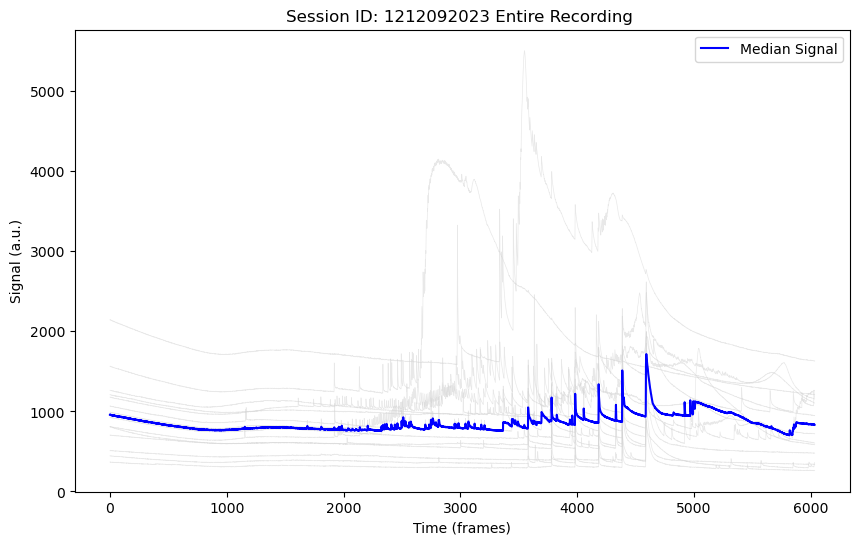

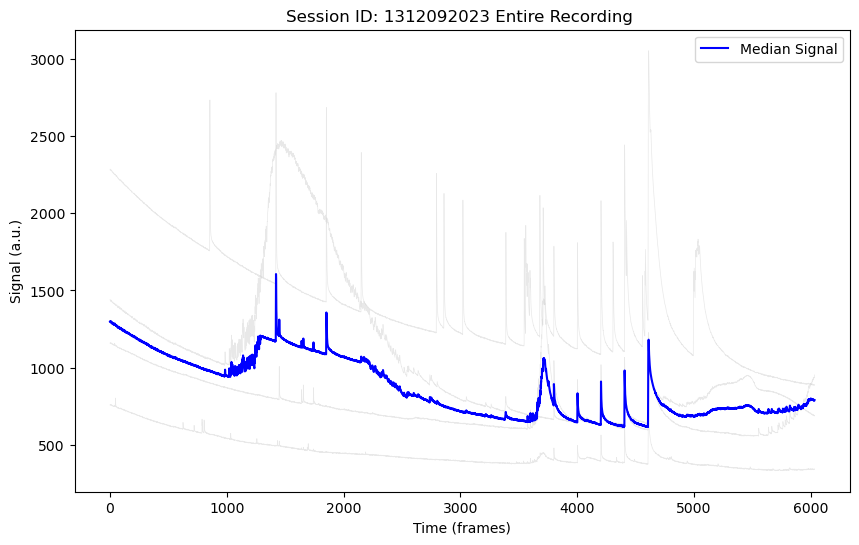

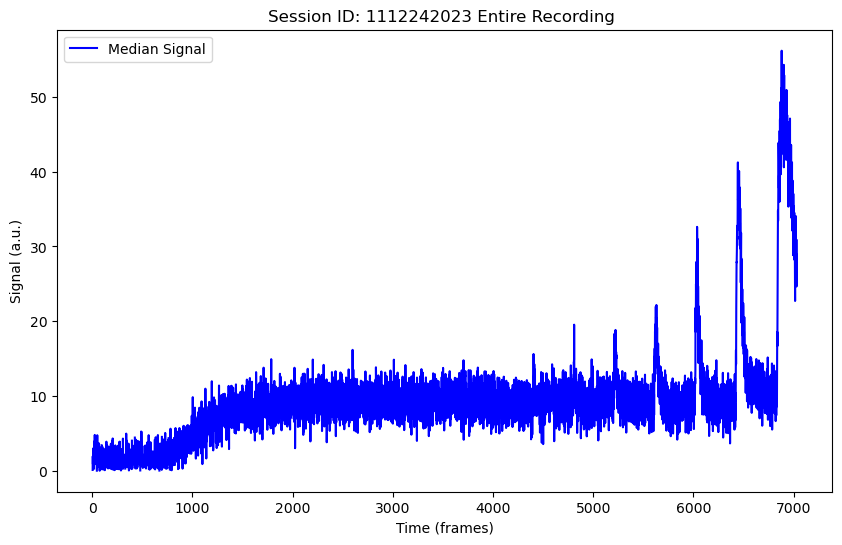

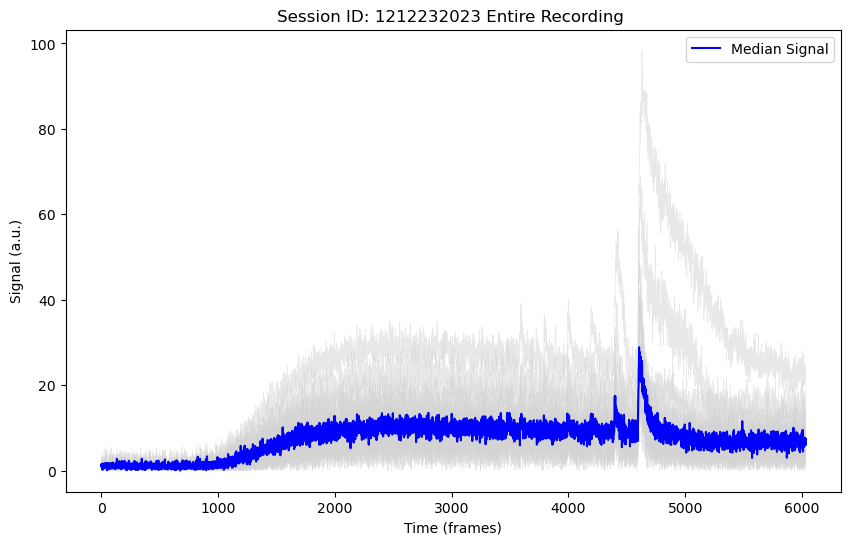

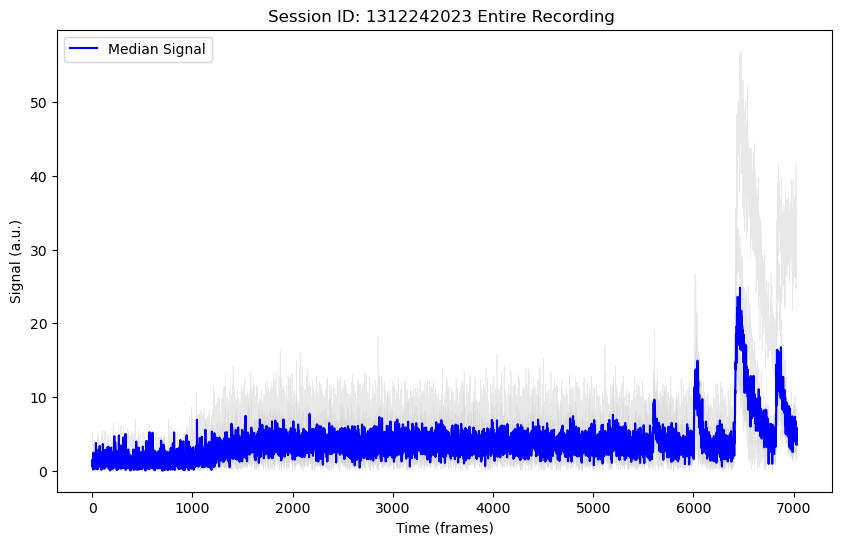

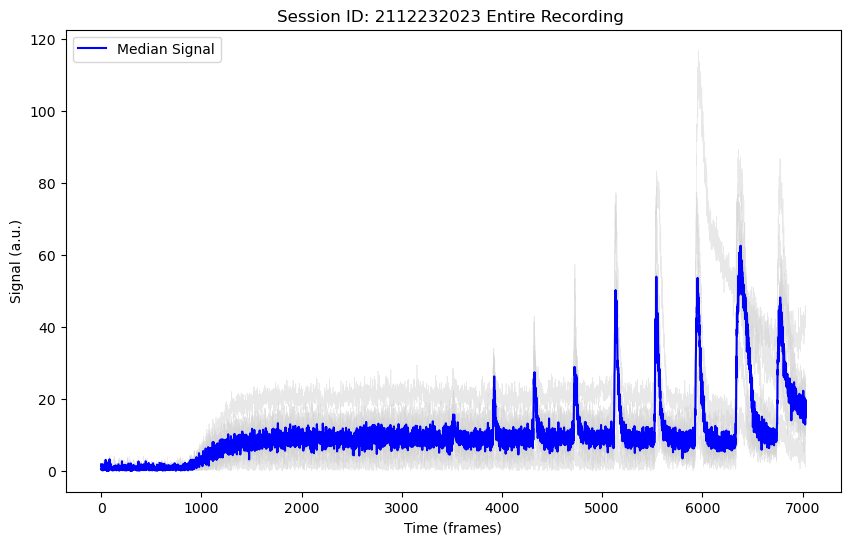

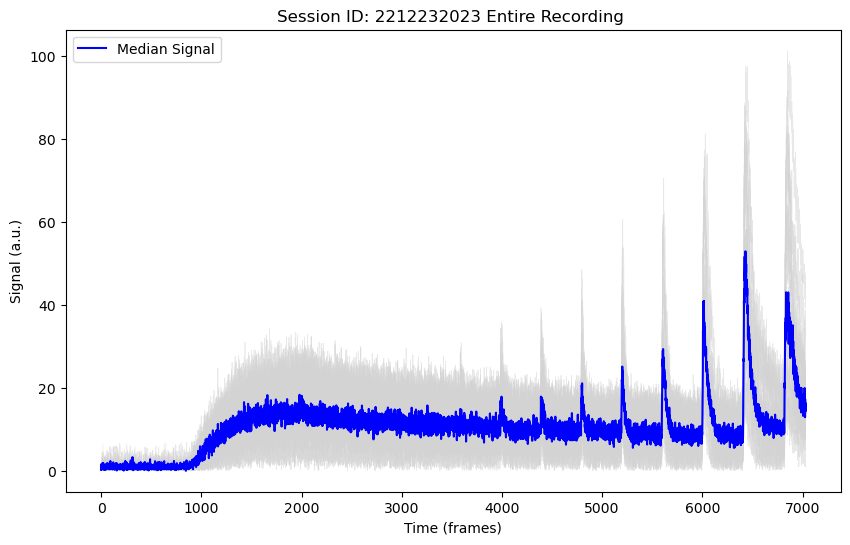

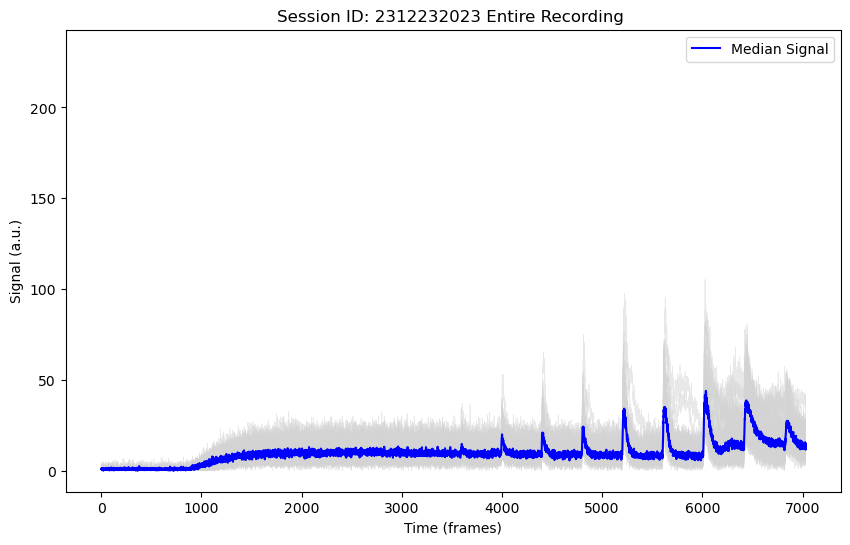

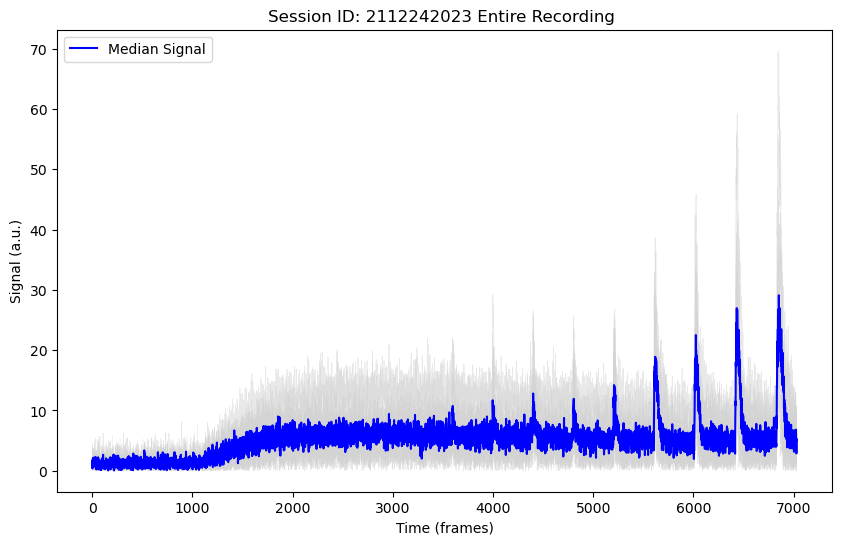

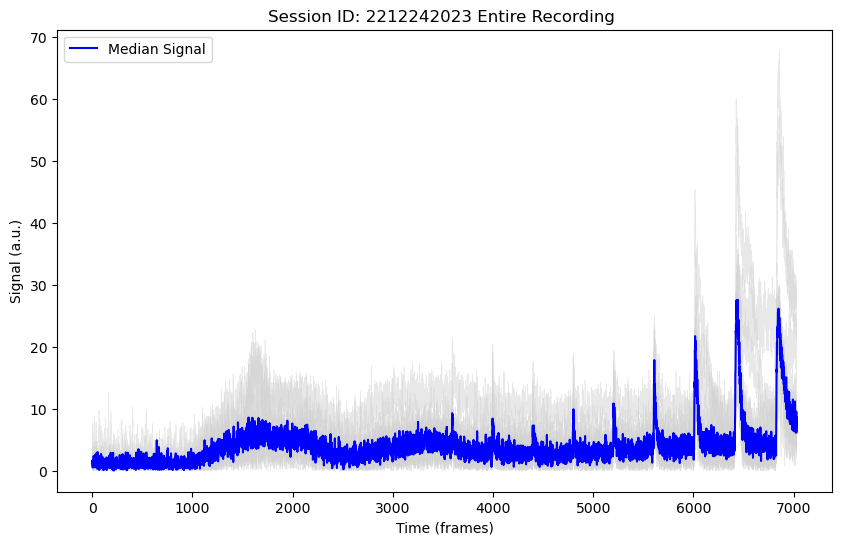

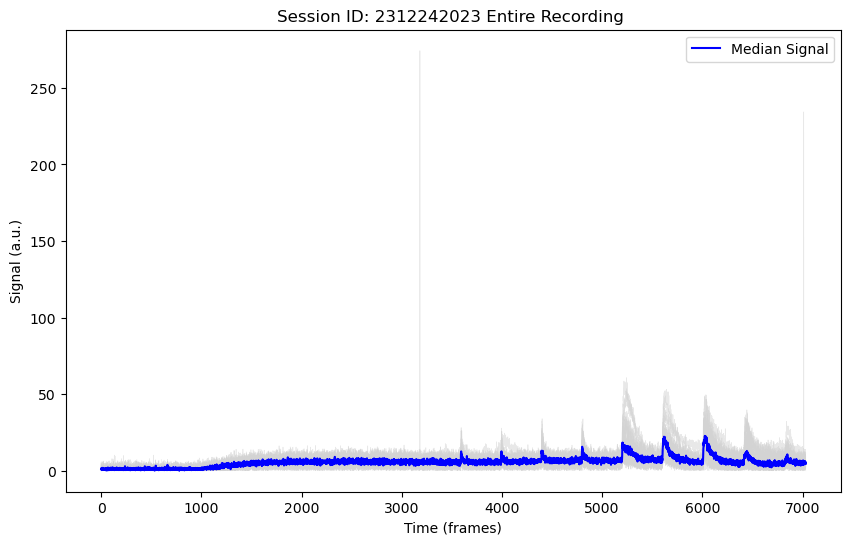

In [42]:
#plots the time series data for  ROIs for each session
analysis_gcamp8.plot_session_time_series(gcamp8_filtered_responsive_rois)
analysis_cablam1x.plot_session_time_series(cablam_filtered_responsive_rois)
analysis_cablam05x.plot_session_time_series(cablam_filtered_responsive_rois05x)

In [43]:
responsiveness_df_gcamp8

,session_id,roi,stimulation_id,stim_frame_number,pre_stim_mean,pre_stim_sd,post_stim_peak,post_stim_sd,post_stim_mean,delta_f_f_post_stim,pre_stim_median,post_stim_median,peak_delta_f_f_post_stim,delta_f_f_full_array,raw_signal,p_value,time_to_peak,half_rise_time,half_decay_time,is_responsive
0,1212092023,ROI_1,12,3579,1077.366667,21.206869,1241.052083,20.343635,1119.458854,"[0.15193102007982406, 0.09558704093313924, 0.0...",1070.273438,1105.934896,0.151931,"[-0.007108381547600813, -0.006895671544816176,...","[1069.7083333333333, 1069.9375, 1069.385416666...",4.847458e-04,100,0,NaN,True
1,1212092023,ROI_1,24,3780,1079.397396,6.074112,1461.307292,52.316868,1170.807552,"[0.35381769245282024, 0.22706390477325544, 0.1...",1077.299479,1133.960938,0.353818,"[-0.0008699877391079873, -0.002245176345018982...","[1078.4583333333333, 1076.9739583333333, 1076....",1.404726e-04,100,0,NaN,True
2,1212092023,ROI_1,36,3982,1127.498437,133.154011,1376.114583,43.414501,1159.245312,"[0.22050243048193435, 0.1371274073273384, 0.09...",1083.054688,1130.177083,0.220502,"[-0.04011784938726349, -0.038939909839121094, ...","[1082.265625, 1083.59375, 1082.8177083333333, ...",5.118468e-01,100,0,NaN,False
3,1212092023,ROI_1,60,4183,1100.876562,61.368220,1696.843750,99.384203,1248.706250,"[0.5413569584464655, 0.3826718576058948, 0.282...",1080.752604,1187.825521,0.541357,"[-0.017851778152163728, -0.018239726581516597,...","[1081.2239583333333, 1080.796875, 1080.53125, ...",6.197286e-04,100,0,NaN,True
4,1212092023,ROI_1,120,4385,1153.224479,143.459681,2145.630208,183.320432,1539.940104,"[0.8605486157246598, 0.7075852986485809, 0.596...",1105.523438,1460.255208,0.860549,"[-0.03851564747575973, -0.03972150550697745, -...","[1108.8072916666667, 1107.4166666666667, 1104....",9.843226e-06,100,0,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,1312092023,ROI_18,24,3800,1031.998701,3.310171,1077.863636,7.682192,1043.985065,"[0.044442822464037086, 0.030650395965966564, 0...",1031.032468,1039.542208,0.044443,"[0.0013666583190605262, -0.0002378438511072363...","[1033.409090909091, 1031.753246753247, 1030.40...",1.641796e-04,100,0,NaN,True
230,1312092023,ROI_18,36,4001,1022.543506,0.462072,1099.714286,12.199158,1044.736039,"[0.07546943355536286, 0.05416401804260684, 0.0...",1022.636364,1037.571429,0.075469,"[8.445962036356637e-05, -0.0002013060124451801...","[1022.62987012987, 1022.3376623376624, 1023.37...",2.206544e-05,100,0,NaN,True
231,1312092023,ROI_18,60,4203,1022.590260,13.592364,1121.383117,16.920684,1051.187013,"[0.0966104030444713, 0.07193408132772079, 0.05...",1018.191558,1042.168831,0.096610,"[-0.005650915773478152, -0.005771566857528286,...","[1016.8116883116884, 1016.6883116883116, 1017....",3.389577e-04,100,0,NaN,True
232,1312092023,ROI_18,120,4404,1009.459091,1.063509,1245.785714,44.538593,1088.402273,"[0.23411213540490686, 0.19897051719224712, 0.1...",1009.168831,1062.681818,0.234112,"[-0.0006220381623950887, 0.001224135080700909,...","[1008.8311688311688, 1010.6948051948052, 1011....",7.342823e-06,100,0,NaN,True


/var/folders/pm/pt74stnd1pn98pmc9gmv1wj80000gn/T/ipykernel_23544/1011549889.py:1206: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(session_df_filtered.columns))
/var/folders/pm/pt74stnd1pn98pmc9gmv1wj80000gn/T/ipykernel_23544/1011549889.py:1206: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(session_df_filtered.columns))


Figure saved as /Volumes/MannySSD/cablam_imaging/cablam_final_figs/individual_session_comparisons/compare_sessions_1212092023_2112232023.svg


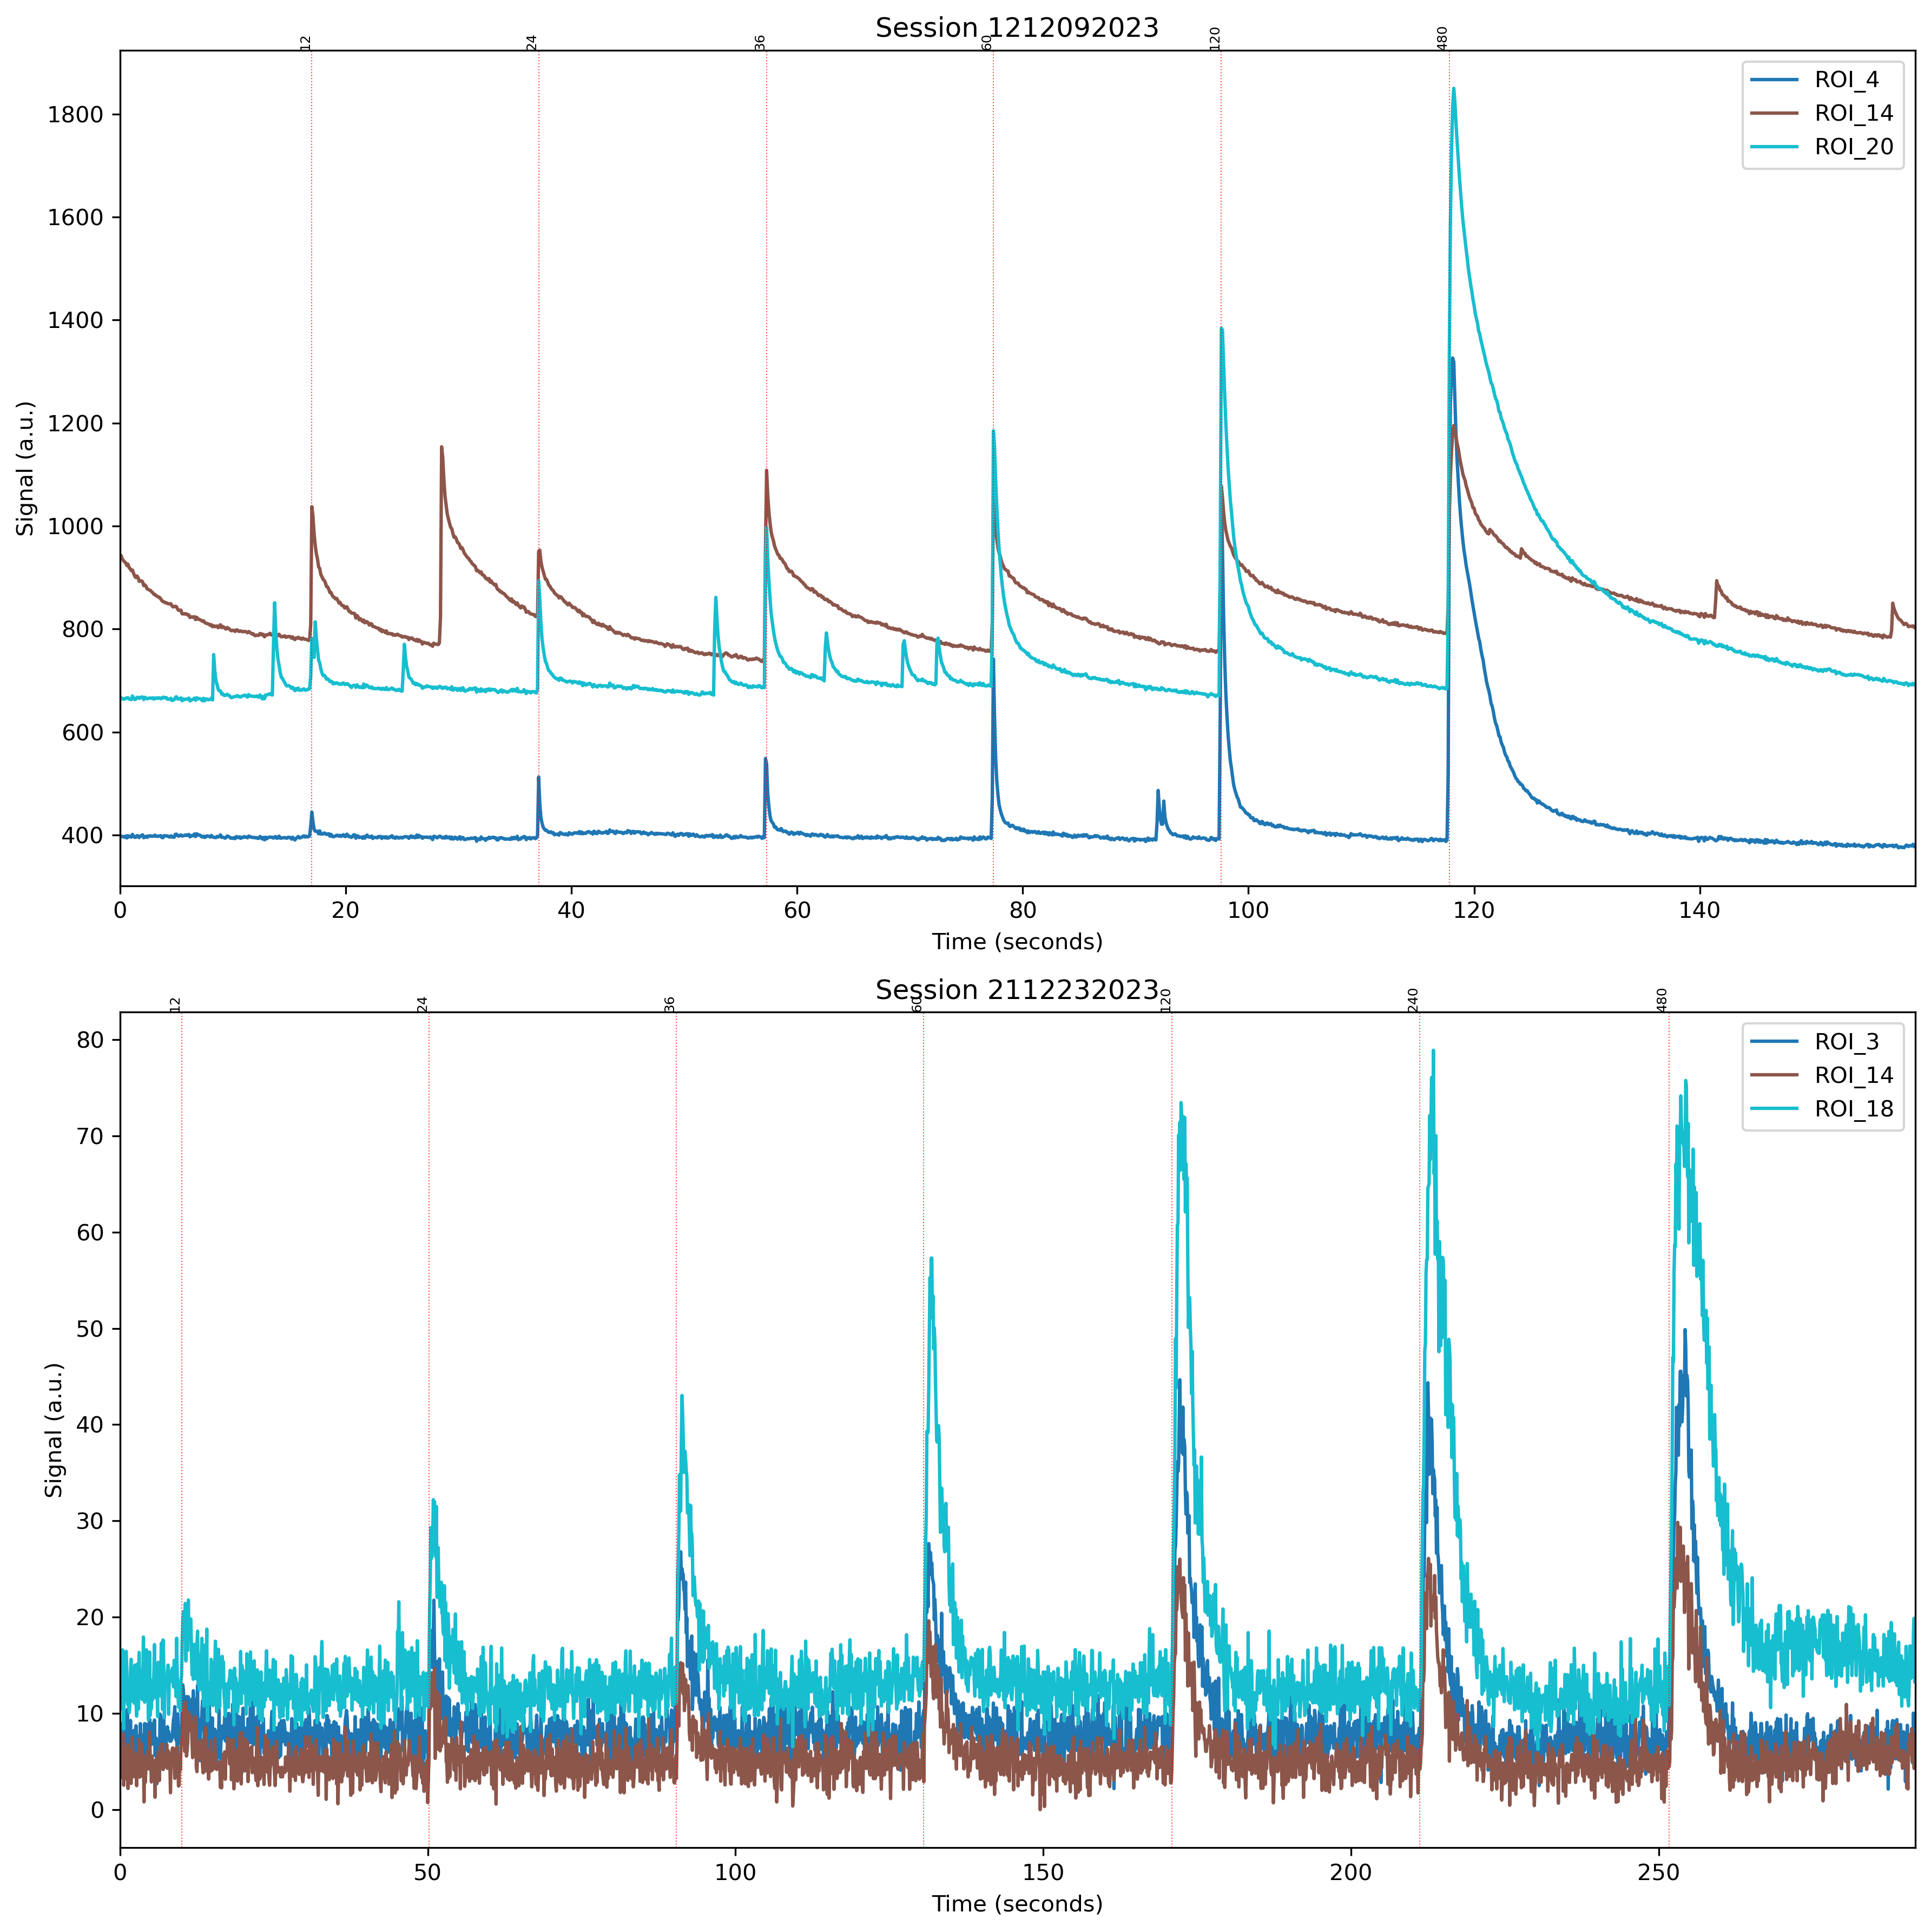

In [44]:
comparison_directory_path = '/Volumes/MannySSD/cablam_imaging/cablam_final_figs/individual_session_comparisons' #path to the directory where the comparison plots will be saved 

# Call the new method
analysis_gcamp8.compare_sessions_time_series(
    session_data_list=[gcamp8_filtered_responsive_rois, cablam_filtered_responsive_rois],
    roi_lists=[['ROI_4', 'ROI_14', 'ROI_20'], ['ROI_18', 'ROI_3', 'ROI_14']],
    frame_ranges=[(3409, 5000), (3409, 6326)],
    session_labels=['1212092023', '2112232023'], 
    fig_size=(12, 6),
    dpi=300,
    save_dir=comparison_directory_path,
    responsiveness_dfs=[responsiveness_df_gcamp8, responsiveness_df_cablam1x]
)

In [ ]:
# Run the method with specific ROIs for session 1212092023
analysis_gcamp8.plot_session_time_series_for_specific_rois(
    gcamp8_filtered_responsive_rois, 
    ['ROI_4', 'ROI_14', 'ROI_20'],  # List of ROIs to include in the plot, 
    frame_range=(0, 5000)  # Only plot frames from 1000 to 2000 (this will be converted to seconds)
)

# Run the method with specific ROIs for session 1212092023
analysis_gcamp8.plot_session_time_series_for_specific_rois(
    gcamp8_filtered_responsive_rois, 
    ['ROI_4', 'ROI_14', 'ROI_20'],  # List of ROIs to include in the plot, 
    frame_range=(3478, 5000)  # Only plot frames from 1000 to 2000 (this will be converted to seconds)
)

# Run the method with specific ROIs for session 1212092023
analysis_gcamp8.plot_session_time_series_for_specific_rois(
    gcamp8_filtered_responsive_rois, 
    ['ROI_4', 'ROI_14', 'ROI_20'],  # List of ROIs to include in the plot, 
    frame_range=(3409, 5000)  # Only plot frames from 1000 to 2000 (this will be converted to seconds)
)


analysis_cablam1x.plot_session_time_series_for_specific_rois(
    cablam_filtered_responsive_rois, 
    ['ROI_18', 'ROI_3', 'ROI_14'], 
    frame_range=(0, 6326),
)


analysis_cablam1x.plot_session_time_series_for_specific_rois(
    cablam_filtered_responsive_rois, 
    ['ROI_18', 'ROI_3', 'ROI_14'], 
    frame_range=(3409, 6326),
)

In [ ]:
# Run the method with specific ROIs for session 1212092023
analysis_gcamp8.plot_session_time_series_for_specific_rois(
    gcamp8_filtered_responsive_rois, 
    ['ROI_4', 'ROI_14', 'ROI_20'],  # List of ROIs to include in the plot, 
    frame_range=(0, 5000)  # Only plot frames from 1000 to 2000 (this will be converted to seconds)
)

In [ ]:
### plot the time locked responses for the gcamp8, cablam1x, and cablam05x data ###
analysis_gcamp8.plot_stim_responsiveness(
    df=responsiveness_df_gcamp8,
    include='responsive',
    y_lim=None,
    x_lim=(-10, 100),
    mean_color='black',
    figsize=(20, 6)
)

analysis_cablam05x.plot_stim_responsiveness(
    df=responsiveness_df_cablam05x,
    include='responsive',
    y_lim=None,
    x_lim=(-10, 100),
    mean_color='blue',
    figsize=(20, 6)
)

analysis_cablam1x.plot_stim_responsiveness(
    df=responsiveness_df_cablam1x,
    include='responsive',
    y_lim=None,
    x_lim=(-10, 100),
    mean_color='red',
    figsize=(20, 6)
)

In [ ]:
## check how many ROIs are being plotted for each session
def count_and_list_rois_per_stim(df, stim_ids=None, include='both'):
    """
    Counts and lists the ROIs being plotted for each stimulation condition, optionally filtering by responsiveness.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing the responsiveness data.
    stim_ids : list, optional
        List of stimulation IDs to filter on. If None, all unique IDs in the DataFrame will be used.
    include : str, optional
        Filter for 'responsive', 'non-responsive', or 'both' units.

    Returns
    -------
    dict
        A dictionary where each key is a stimulation ID and the value is a dictionary containing:
            - 'num_rois': The number of ROIs plotted for that stimulation.
            - 'rois': A list of the ROIs being plotted for that stimulation.
    """
    
    # If stim_ids is not provided, get the unique IDs from the DataFrame and sort them
    if stim_ids is None:
        stim_ids = sorted(df['stimulation_id'].unique())
    else:
        stim_ids = sorted(stim_ids)
    
    # Dictionary to hold the ROI counts and lists per stimulation
    rois_per_stim = {}

    for stim_id in stim_ids:
        # Filter the DataFrame based on the current stim_id
        stim_df = df[df['stimulation_id'] == stim_id]

        # Filter based on responsiveness if required
        if include != 'both':
            stim_df = stim_df[stim_df['is_responsive'] == (include == 'responsive')]
        
        # Get the unique ROIs for this stim_id
        unique_rois = stim_df['roi'].unique()
        
        # Store the number of ROIs and the actual ROIs for this stimulation ID
        rois_per_stim[stim_id] = {
            'num_rois': len(unique_rois),
            'rois': unique_rois.tolist()  # Convert the array to a list for easier readability
        }
    
    return rois_per_stim

# Assuming you have your data in a DataFrame called df
rois_per_stim = count_and_list_rois_per_stim(responsiveness_df_cablam1x, include='responsive')

# To view the output
for stim_id, roi_info in rois_per_stim.items():
    print(f"Stimulation ID: {stim_id}")
    print(f"Number of ROIs: {roi_info['num_rois']}")
    print(f"ROIs: {roi_info['rois']}")

In [ ]:
# Assuming you have your data in a DataFrame called d
rois_per_stim = count_and_list_rois_per_stim(responsiveness_df_gcamp8, include='responsive')

# To view the output
for stim_id, roi_info in rois_per_stim.items():
    print(f"Stimulation ID: {stim_id}")
    print(f"Number of ROIs: {roi_info['num_rois']}")
    print(f"ROIs: {roi_info['rois']}")

# Using the SensorDataPlotter class methods 

### compare GCaMP8 and Cablam1x

In [36]:
# Sensor names
sensor_names_cablamvsgcamp = ['CaBLAM1x', 'GCaMP8s']

# Dictionaries for sensor colors (boxplot and stripplot)
sensor_box_colors2 = {
    'CaBLAM1x': '#0000ff',   # Dark blue
    'GCaMP8s': '#d3d3d3'   # Light grey
}

sensor_strip_colors2 = {
    'CaBLAM1x': '#0000ff',   # Dark blue
    'GCaMP8s': '#808080'   # Dark grey
}
# Initialize the SensorDataPlotter object
cablamvsgcamp_plotter = SensorDataPlotter(
    data_frames=[responsiveness_df_cablam1x, responsiveness_df_gcamp8],
    sensor_names=sensor_names_cablamvsgcamp,
    sensor_box_colors=sensor_box_colors2,
    sensor_strip_colors=sensor_strip_colors2
) 

boxplot_directory_path = '/Volumes/MannySSD/cablam_imaging/cablam_final_figs/box_plots'
cumulative_directory_path = '/Volumes/MannySSD/cablam_imaging/cablam_final_figs/cumlativedistribution'
mean_error_lineplots_directory_path = '/Volumes/MannySSD/cablam_imaging/cablam_final_figs/mean_error_deltaf'
timeseries_directory_path = '/Volumes/MannySSD/cablam_imaging/cablam_final_figs/time_series_allrois'


In [ ]:
cablamvsgcamp_plotter.plot_data('peak_delta_f_f_post_stim', 
                                selected_stim_ids=[12, 60, 480],
                                strip_size=5, 
                                save_dir=boxplot_directory_path, 
                                save_dpi=300)

In [ ]:
cablamvsgcamp_plotter.plot_cumulative_distribution(
    column_name='time_to_peak',
    selected_stim_ids=[12, 60, 480],
    save_dir=cumulative_directory_path,
    save_dpi=300, 
    num_points=40, 
    fig_size= (3,5)# Adjust this value to change the step size
)

In [ ]:
### run stats test for the cablam vs gcamp8 data on the time to peak data
ks_results = cablamvsgcamp_plotter.run_ks_test(
    column_name='time_to_peak',
    selected_stim_ids=[12, 60, 480]
)

ks_results

In [ ]:
cablamvsgcamp_plotter.plot_time_series(
    'delta_f_f_full_array',
    selected_stim_ids=[12, 60, 480],  # List of stimulation IDs to plot
    fig_size=(6.5, 8),  # Figure size
    dpi=300,  # Display resolution
    y_limits=None,  # Set custom y-axis limits (min, max)
    save_dir=timeseries_directory_path,  # Directory where the plot will be saved
    save_dpi=300,  # Resolution for saving the figure
    plot_sem=True,  # Enable plotting of the SEM, 
    plot_sem_as_dotted=True)  # Plot the SEM as dotted lines instead of a shaded region)

In [47]:
### repeat the comparison for the cablam05x data and cablam1x data
sensor_names_cablam05xvscablam1x = ['CaBLAM05x', 'CaBLAM1x']

# Dictionaries for sensor colors (boxplot and stripplot)
sensor_box_colors3 = {
    'CaBLAM05x': '#9999ff',  # Light blue
    'CaBLAM1x': '#0000ff'   # Dark blue
}

sensor_strip_colors3 = {
    'CaBLAM05x': '#9999ff', # Light blue
    'CaBLAM1x': '#0000ff'   # Dark blue
}

# Initialize the SensorDataPlotter object
cablam05xvscablam1x_plotter = SensorDataPlotter(
    data_frames=[responsiveness_df_cablam05x, responsiveness_df_cablam1x],
    sensor_names=sensor_names_cablam05xvscablam1x,
    sensor_box_colors=sensor_box_colors3,
    sensor_strip_colors=sensor_strip_colors3
)


In [ ]:
cablam05xvscablam1x_plotter.plot_data('peak_delta_f_f_post_stim', 
                                selected_stim_ids=[12, 24, 120, 480, 1920],
                                strip_size=5, 
                                save_dir=boxplot_directory_path, 
                                save_dpi=300)



In [ ]:
cablam05xvscablam1x_plotter.plot_cumulative_distribution(
    column_name='time_to_peak',
    selected_stim_ids=[12, 24, 120, 480, 1920],
    save_dir=cumulative_directory_path,
    save_dpi=300, 
    num_points=40, 
    fig_size= (3,5)
)

In [ ]:
### run stats test for the cablam vs gcamp8 data on the time to peak data
ks_results_cablam05xvscablam1x_plotter = cablam05xvscablam1x_plotter.run_ks_test(
    column_name='time_to_peak',
    selected_stim_ids=[12, 24, 120, 480, 1920]
)

ks_results_cablam05xvscablam1x_plotter

In [ ]:
## for some reason, I haev to reinitlaize the plotter object to run the plot_mean_with_error function with different stim ids 
## need to fix this in the future

# Initialize the SensorDataPlotter object
cablam05xvscablam1x_plotter = SensorDataPlotter(
    data_frames=[responsiveness_df_cablam05x, responsiveness_df_cablam1x],
    sensor_names=sensor_names_cablam05xvscablam1x,
    sensor_box_colors=sensor_box_colors3,
    sensor_strip_colors=sensor_strip_colors3
)


cablam05xvscablam1x_plotter.plot_mean_with_error(
    'peak_delta_f_f_post_stim',
    error_type='SEM',
    selected_stim_ids=[12, 24, 36, 60, 120, 240, 480, 1920],
    save_dir=mean_error_lineplots_directory_path,
    save_dpi=300, 
    fig_size= (4,5)
)


In [ ]:
cablam05xvscablam1x_plotter.plot_time_series(
    'delta_f_f_full_array',
    selected_stim_ids=[12, 24, 120, 480, 1920],  # List of stimulation IDs to plot
    fig_size=(6.5, 8),  # Figure size
    dpi=300,  # Display resolution
    y_limits=None,  # Set custom y-axis limits (min, max)
    save_dir=timeseries_directory_path,  # Directory where the plot will be saved
    save_dpi=300,  # Resolution for saving the figure
    plot_sem=True,  # Enable plotting of the SEM, 
    plot_sem_as_dotted=True  # Plot the SEM as dotted lines instead of a shaded region
)

### Analyze a single sensor

In [57]:
# Sensor names
sensor_names_gcamp = ['GCaMP8s']

# Dictionaries for sensor colors (boxplot and stripplot)
sensor_box_colors_gcamp = {
    'GCaMP8s': '#d3d3d3'   # Light grey
}

sensor_strip_colors_gcamp = {
    'GCaMP8s': '#808080'   # Dark grey
}

# Initialize the SensorDataPlotter object
gcamp_plotter = SensorDataPlotter(
    data_frames=[responsiveness_df_gcamp8],
    sensor_names=sensor_names_gcamp,
    sensor_box_colors=sensor_box_colors_gcamp,
    sensor_strip_colors=sensor_strip_colors_gcamp
)

In [ ]:
gcamp_plotter.plot_mean_with_error(
    'peak_delta_f_f_post_stim',
    error_type='SEM',
    selected_stim_ids=[12, 24, 120, 480],
    save_dir=mean_error_lineplots_directory_path,
    save_dpi=300
)


gcamp_plotter.plot_time_series(
    'delta_f_f_full_array',
    selected_stim_ids=[12, 24, 120, 480],  # List of stimulation IDs to plot
    fig_size=(6.5, 8),  # Figure size
    dpi=300,  # Display resolution
    y_limits=None,  # Set custom y-axis limits (min, max)
    save_dir=timeseries_directory_path,  # Directory where the plot will be saved
    save_dpi=300,  # Resolution for saving the figure
    plot_sem=True,  # Enable plotting of the SEM, 
    plot_sem_as_dotted=True  # Plot the SEM as dotted lines instead of a shaded region
)

### heatmaps 

# heatmaps

### must re runn this as a group, need to update the udnerlyuin gmethod to handle this 

In [ ]:
## repeat the same process for the cablam data
# Sensor names
sensor_names_cablam = ['CaBLAM1x']

# Dictionaries for sensor colors (boxplot and stripplot)
sensor_box_colors_cablam = {
    'CaBLAM1x': '#ccccff'   # Light blue
}

sensor_strip_colors_cablam = {
    'CaBLAM1x': '#0000ff'   # Dark blue
}

# Initialize the SensorDataPlotter object
cablam_plotter = SensorDataPlotter(
    data_frames=[responsiveness_df_cablam1x],
    sensor_names=sensor_names_cablam,
    sensor_box_colors=sensor_box_colors_cablam,
    sensor_strip_colors=sensor_strip_colors_cablam
)

cablam_plotter.plot_non_responsive_heatmap_and_pie(selected_stim_id=480, 
                                                   vmin=0, 
                                                   vmax=8,
                                                   smooth_method=None, 
                                                   smooth_sigma=1, 
                                                   save_dir='/Volumes/MannySSD/cablam_imaging/cablam_final_figs/heatmaps', 
                                                   save_dpi=300, 
                                                   interpolation='nearest')

In [ ]:
#repeatr for the cablam05x data
# Sensor names
sensor_names_cablam05x = ['CaBLAM05x']

# Dictionaries for sensor colors (boxplot and stripplot)
sensor_box_colors_cablam05x = {
    'CaBLAM05x': '#9999ff'   # Light blue
}

sensor_strip_colors_cablam05x = {
    'CaBLAM05x': '#9999ff'   # Light blue
}

# Initialize the SensorDataPlotter object
cablam05x_plotter = SensorDataPlotter(
    data_frames=[responsiveness_df_cablam05x],
    sensor_names=sensor_names_cablam05x,
    sensor_box_colors=sensor_box_colors_cablam05x,
    sensor_strip_colors=sensor_strip_colors_cablam05x
)

cablam05x_plotter.plot_non_responsive_heatmap_and_pie(selected_stim_id=480,
                                                        vmin=0,
                                                        vmax=8,
                                                        smooth_method=None,
                                                        smooth_sigma=1,
                                                        save_dir='/Volumes/MannySSD/cablam_imaging/cablam_final_figs/heatmaps',
                                                        save_dpi=300,
                                                        interpolation='nearest')

In [ ]:
# repeat for the gcamp8 data
# Sensor names
sensor_names_gcamp = ['GCaMP8s']

# Dictionaries for sensor colors (boxplot and stripplot)
sensor_box_colors_gcamp = {
    'GCaMP8s': '#d3d3d3'   # Light grey
}

sensor_strip_colors_gcamp = {
    'GCaMP8s': '#808080'   # Dark grey
}

# Initialize the SensorDataPlotter object
gcamp_plotter = SensorDataPlotter(
    data_frames=[responsiveness_df_gcamp8],
    sensor_names=sensor_names_gcamp,
    sensor_box_colors=sensor_box_colors_gcamp,
    sensor_strip_colors=sensor_strip_colors_gcamp
)


#repeat for gcamp8 data
gcamp_plotter.plot_non_responsive_heatmap_and_pie(selected_stim_id=480, 
                                                  vmin=0, 
                                                  vmax=None,
                                                  smooth_method=None, 
                                                  smooth_sigma=1, 
                                                  save_dir='/Volumes/MannySSD/cablam_imaging/gcamp8_final_figs/heatmaps', 
                                                  save_dpi=300, 
                                                  interpolation='nearest')



# plot each sensor type

In [ ]:
# Define the directory where you want to save the figures
save_directory = '/Volumes/MannySSD/cablam_imaging/cablam_final_figs/Timeseries_evoked'

gcamp_plotter.plot_single_roi(
    full_array_column='delta_f_f_full_array',  # Replace with the actual column name for time series data
    session_id='1212092023',  # Replace with the session ID you want to plot
    roi='ROI_4',  # Replace with the ROI you want to plot
    selected_stim_ids=[12, 60, 480],  # List of stimulation IDs to plot
    save_dir=save_directory,  # Replace with the directory where you want to save the plot (or None to skip saving)
    y_limits=(-0.5, 1.0)  # Optional: Replace with your desired y-axis limits or leave as None
)

gcamp_plotter.plot_single_roi(
    full_array_column='delta_f_f_full_array',  # Replace with the actual column name for time series data
    session_id='1212092023',  # Replace with the session ID you want to plot
    roi='ROI_14',  # Replace with the ROI you want to plot
    selected_stim_ids=[12, 60, 480],  # List of stimulation IDs to plot
    save_dir=save_directory,  # Replace with the directory where you want to save the plot (or None to skip saving)
    y_limits=(-0.5, 1.0)   # Optional: Replace with your desired y-axis limits or leave as None
)

gcamp_plotter.plot_single_roi(
    full_array_column='delta_f_f_full_array',  # Replace with the actual column name for time series data
    session_id='1212092023',  # Replace with the session ID you want to plot
    roi='ROI_20',  # Replace with the ROI you want to plot
    selected_stim_ids=[12, 60, 480],  # List of stimulation IDs to plot
    save_dir=save_directory,  # Replace with the directory where you want to save the plot (or None to skip saving)
    y_limits=(-0.5, 1.0)   # Optional: Replace with your desired y-axis limits or leave as None
)

In [ ]:
cablam_plotter.plot_single_roi(
    full_array_column='delta_f_f_full_array',  # Replace with the actual column name for time series data
    session_id='2112232023',  # Replace with the session ID you want to plot
    roi='ROI_18',  # Replace with the ROI you want to plot
    selected_stim_ids=[12, 60, 480],  # List of stimulation IDs to plot
    save_dir=save_directory,  # Replace with the directory where you want to save the plot (or None to skip saving)
    y_limits=(-0.9, 7)   # Optional: Replace with your desired y-axis limits or leave as None
)


cablam_plotter.plot_single_roi(
    full_array_column='delta_f_f_full_array',  # Replace with the actual column name for time series data
    session_id='2112232023',  # Replace with the session ID you want to plot
    roi='ROI_3',  # Replace with the ROI you want to plot
    selected_stim_ids=[12, 60, 480],  # List of stimulation IDs to plot
    save_dir=save_directory,  # Replace with the directory where you want to save the plot (or None to skip saving)
    y_limits=(-0.9, 7)   # Optional: Replace with your desired y-axis limits or leave as None
)


cablam_plotter.plot_single_roi(
    full_array_column='delta_f_f_full_array',  # Replace with the actual column name for time series data
    session_id='2112232023',  # Replace with the session ID you want to plot
    roi='ROI_14',  # Replace with the ROI you want to plot
    selected_stim_ids=[12, 60, 480],  # List of stimulation IDs to plot
    save_dir=save_directory,  # Replace with the directory where you want to save the plot (or None to skip saving)
    y_limits=(-0.9, 7)  # Optional: Replace with your desired y-axis limits or leave as None
)

